# Notebook Noé


#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

---

## Functions

This section contains all the functions that are used for further data analysis/processing


In [2]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet(location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)

def load_clean_datasets(location: str, threshold: float,verbose=True):
    """
    Description
    -----------
    Load and preprocess datasets, handling missing values and highly correlated features.

    This function loads four datasets from the specified location and processes them. It replaces colons in column names,
    identifies low-correlation features, and fills missing values using the `fill_nan` function.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `threshold` (float): The threshold for feature correlation identification.
    - `verbose` (bool): whether to display information about the dataset being processed

    Returns
    -------
    - Tuple of DataFrames: A tuple containing four DataFrames for train_target, X_train_observed, X_train_estimated, and X_test_estimated.
    - List of Lists of str: A list of lists containing the names of low-correlation features for each DataFrame.

    Example
    -------
    ```python
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets("data/location", 0.7)
    ```
    """
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = location)


    # Process NaNs and highly correlated features
    dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
    dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
    index = 0
    FEATURES = [] # Contains the list of useful features for each dataframe


    for dataframe in dataframes:
        if verbose:
            print("** WORKING ON "+dataframe_names[index]+"**")
        # Replace colons with underscores in column names of 'dataframe'
        dataframe.columns = dataframe.columns.str.replace(':', '_')
        # Find low find_low_correlation_columns
        features = find_low_correlation_columns(dataframe,threshold,verbose=False)
        FEATURES.append(features)
        # Fill NaN
        for feature in dataframe.columns:
            fill_nan(dataframe,feature,verbose=False)
        index+=1
    return (train_target, X_train_observed, X_train_estimated, X_test_estimated,FEATURES)

def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df

def lagged_features2(df):
    # Define the time intervals for lag
    time_intervals = [15, 30, 45]

    # Create a new DataFrame to store the lagged features
    new_df = df.copy()

    # Loop through the time intervals and create lagged features
    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        # Loop through the columns in the original DataFrame
        for column in df.columns:
            # Exclude the 'date_forecast' and 'date_calc' columns
            if column not in ['date_forecast', 'date_calc']:
                # Shift the values by the specified time interval
                new_df[column + suffix] = new_df[column].copy().shift(periods=interval//15)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)

    return new_df

def lagged_features(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc', 'sin_day', 'sin_year',' cos_year', 'forecast_interval']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def lagged_features_selected(df,feature_list: list, time_intervals = [15,30,45],verbose=False):

    if feature_list not in df.columns:
        ValueError("Features are not in the DataFrame columns")

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for feature in feature_list:
            if column not in ['date_forecast', 'date_calc', 'sin_day', 'sin_year',' cos_year', 'forecast_interval']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def normalize_dataframe_minmax(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using min-max scaling, excluding datetime columns.

    This function performs min-max scaling to normalize each column in the DataFrame between 0 and 1,
    excluding datetime columns. It replaces the original values with the scaled values.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized between -1 and 1.

    Example
    -------
    ```python
    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50],
            'date': pd.date_range(start='2023-01-01', periods=5, freq='D')}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe(df)
    ```
    """
    normalized_df = df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_minmax_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using min-max scaling, based on statistics from a training DataFrame.

    This function performs min-max scaling to normalize each column in the test DataFrame between 0 and 1,
    using the minimum and maximum values from the corresponding columns in the training DataFrame.
    
    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate min-max scaling statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on the statistics from the training DataFrame.

    Example
    -------
    ```python
    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_TEST(train_df, test_df)
    ```
    """

    normalized_df = test_df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = train_df[column].min()
            max_val = train_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df



def normalize_dataframe_mean_std_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using mean and standard deviation scaling, based on statistics from a training DataFrame.

    This function performs mean and standard deviation scaling to normalize each column in the test DataFrame using the
    mean and standard deviation values from the corresponding columns in the training DataFrame.

    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate mean and standard deviation statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on mean and standard deviation
    statistics from the training DataFrame.

    Example
    -------
    ```python
    import pandas as pd

    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_mean_std_TEST(train_df, test_df)
    ```
    """
    normalized_df = test_df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = train_df[column].mean()
            std = train_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df


def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cosine of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

def full_data_loader(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[1][1:] # all low correlation features from X_train_observed except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        # 
    else:
        X_Test = X_test_estimated
    
    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]


    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal


    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year','forecast_interval']

    print("\nDone\n")
    return (X_Train,Y_Train['pv_measurement'],X_Test,selected_features)


## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [ ]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

In [5]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    print(feature_name)
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

absolute_humidity_2m:gm3
air_density_2m:kgm3
ceiling_height_agl:m
clear_sky_energy_1h:J
clear_sky_rad:W
cloud_base_agl:m
dew_or_rime:idx
dew_point_2m:K
diffuse_rad:W
diffuse_rad_1h:J
direct_rad:W
direct_rad_1h:J
effective_cloud_cover:p
elevation:m
fresh_snow_12h:cm
fresh_snow_1h:cm
fresh_snow_24h:cm
fresh_snow_3h:cm


KeyboardInterrupt: 

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

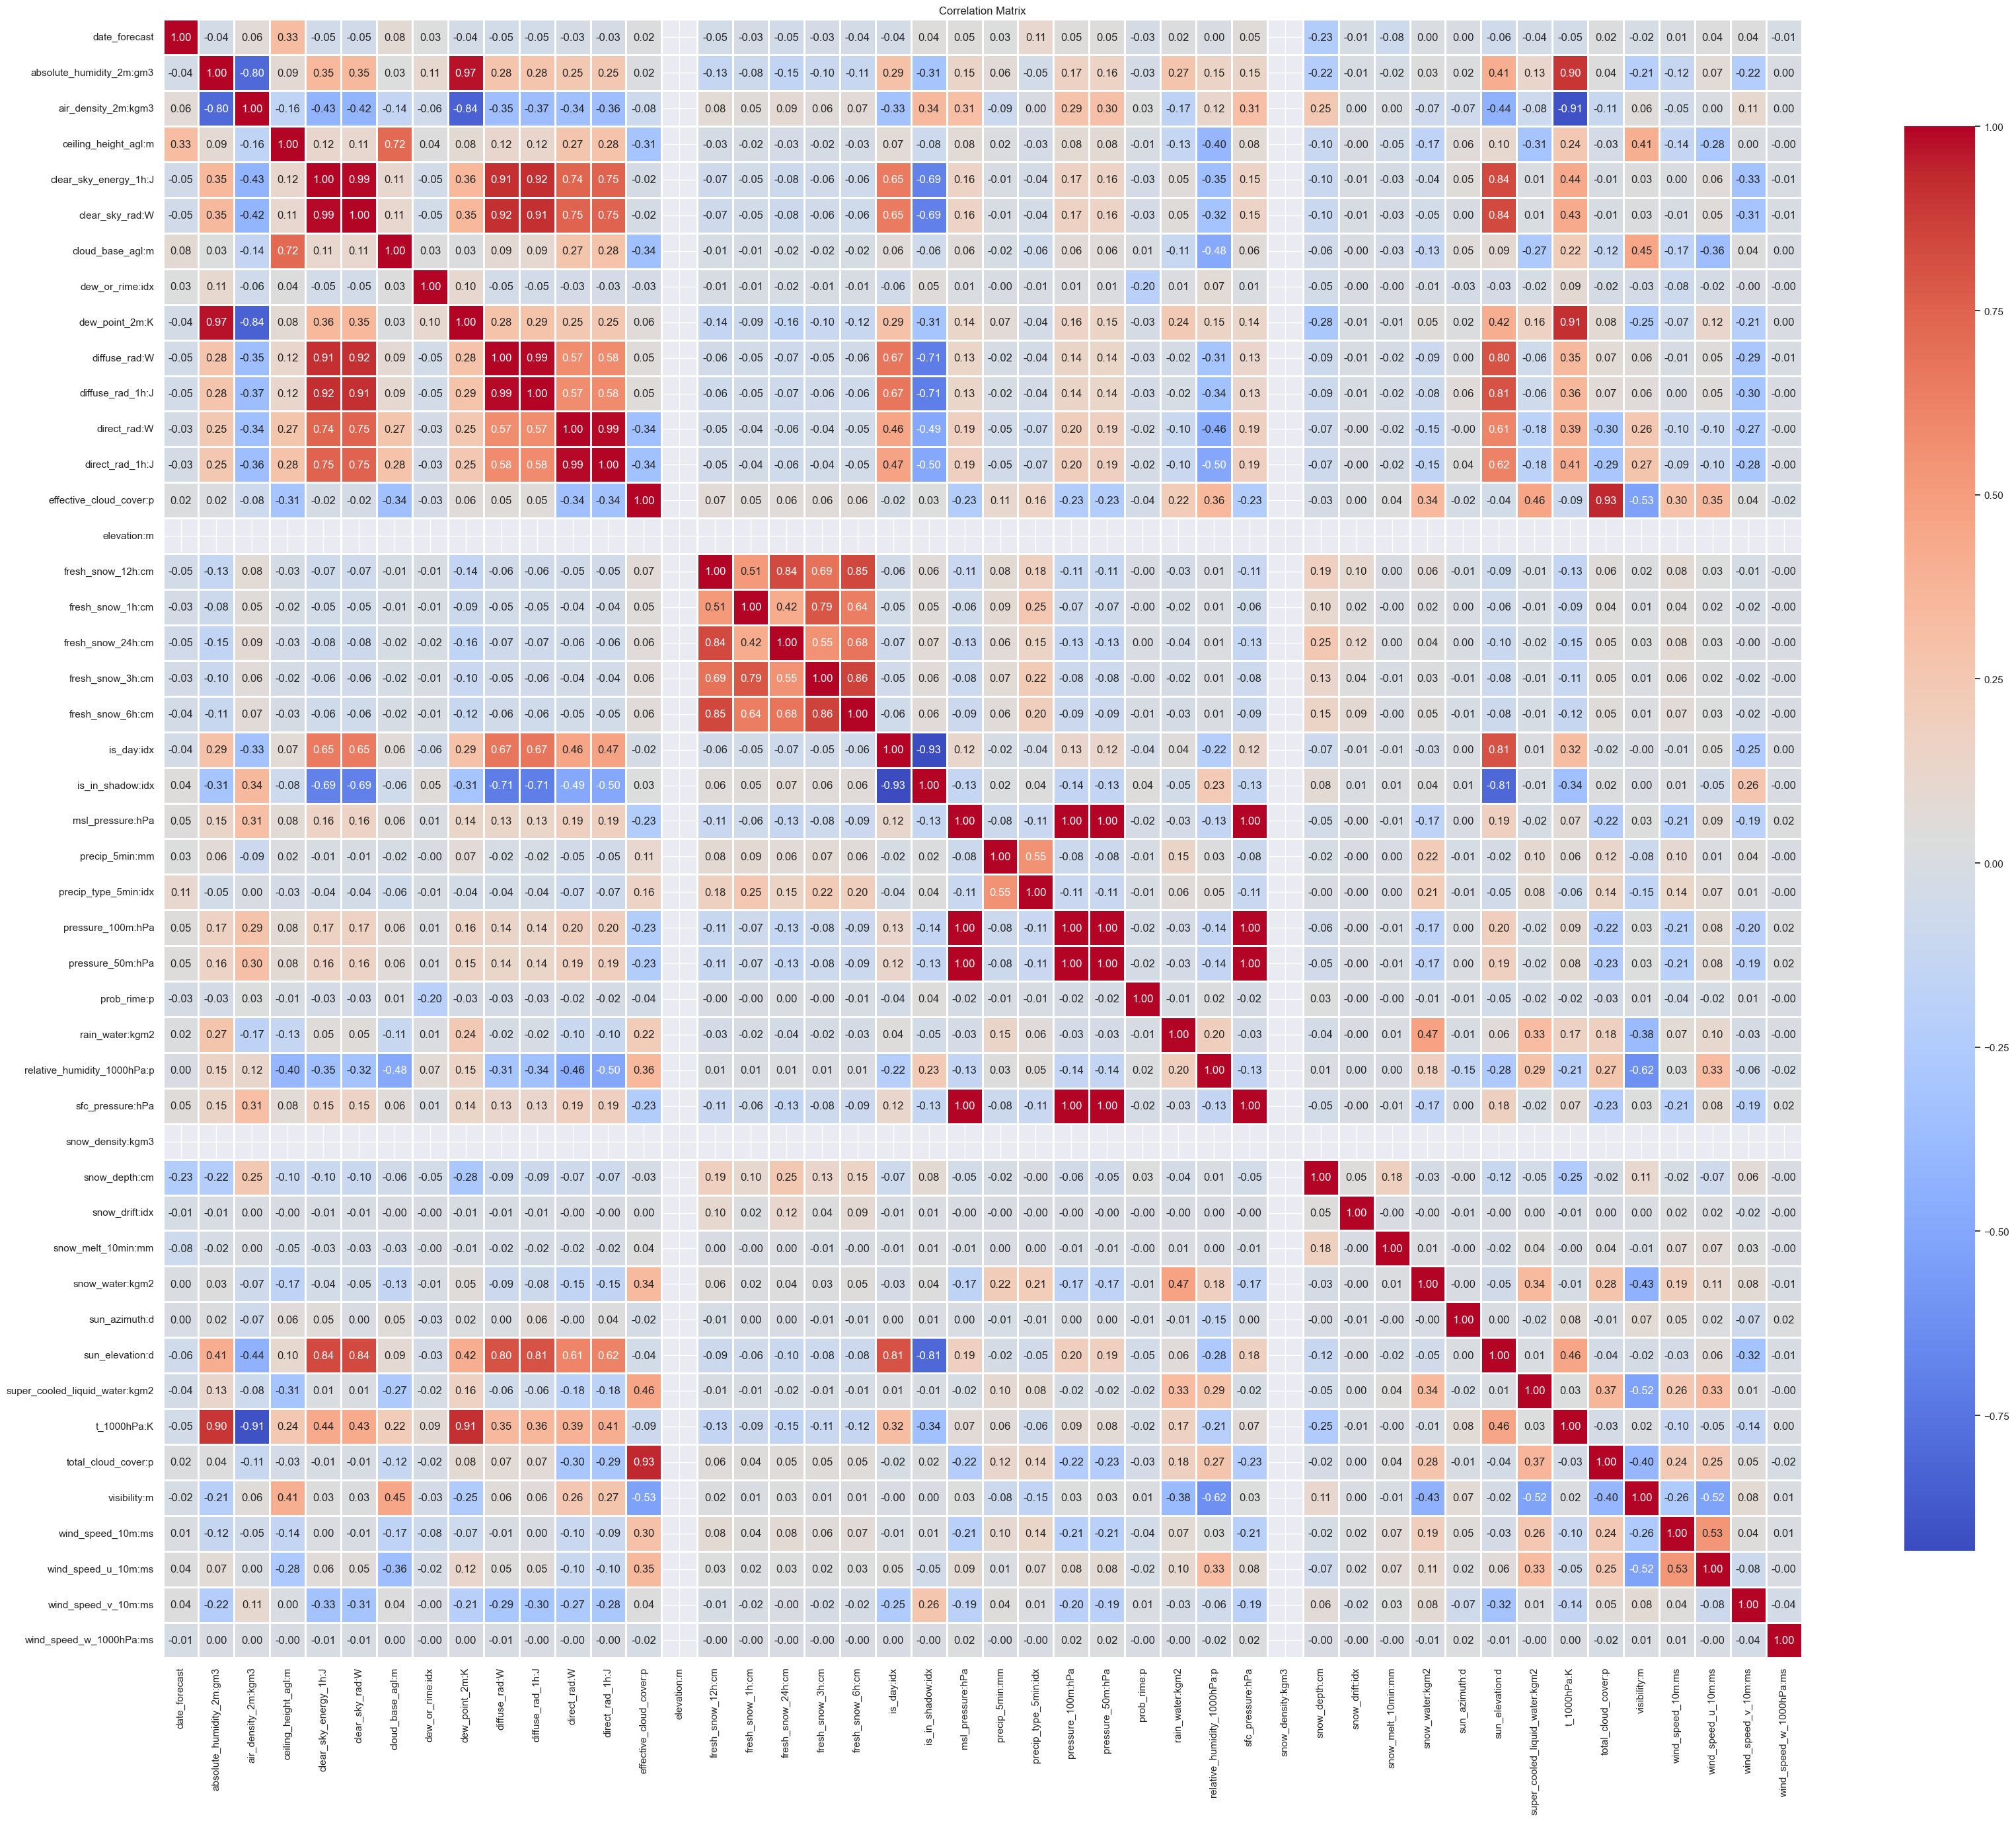

In [16]:
location = 'B'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

Removed elevation:m because it is NaN
Removed snow_density:kgm3 because it is NaN
Removed 	dew_point_2m:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	t_1000hPa:K	because it is correlated to	air_density_2m:kgm3
Removed 	clear_sky_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad_1h:J	because it is correlated to	clear_sky_energy_1h:J
Removed 	direct_rad_1h:J	because it is correlated to	direct_rad:W
Removed 	total_cloud_cover:p	because it is correlated to	effective_cloud_cover:p
Removed 	is_in_shadow:idx	because it is correlated to	is_day:idx
Removed 	pressure_100m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	pressure_50m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	sfc_pressure:hPa	because it is correlated to	msl_pressure:hPa
33 features remaining


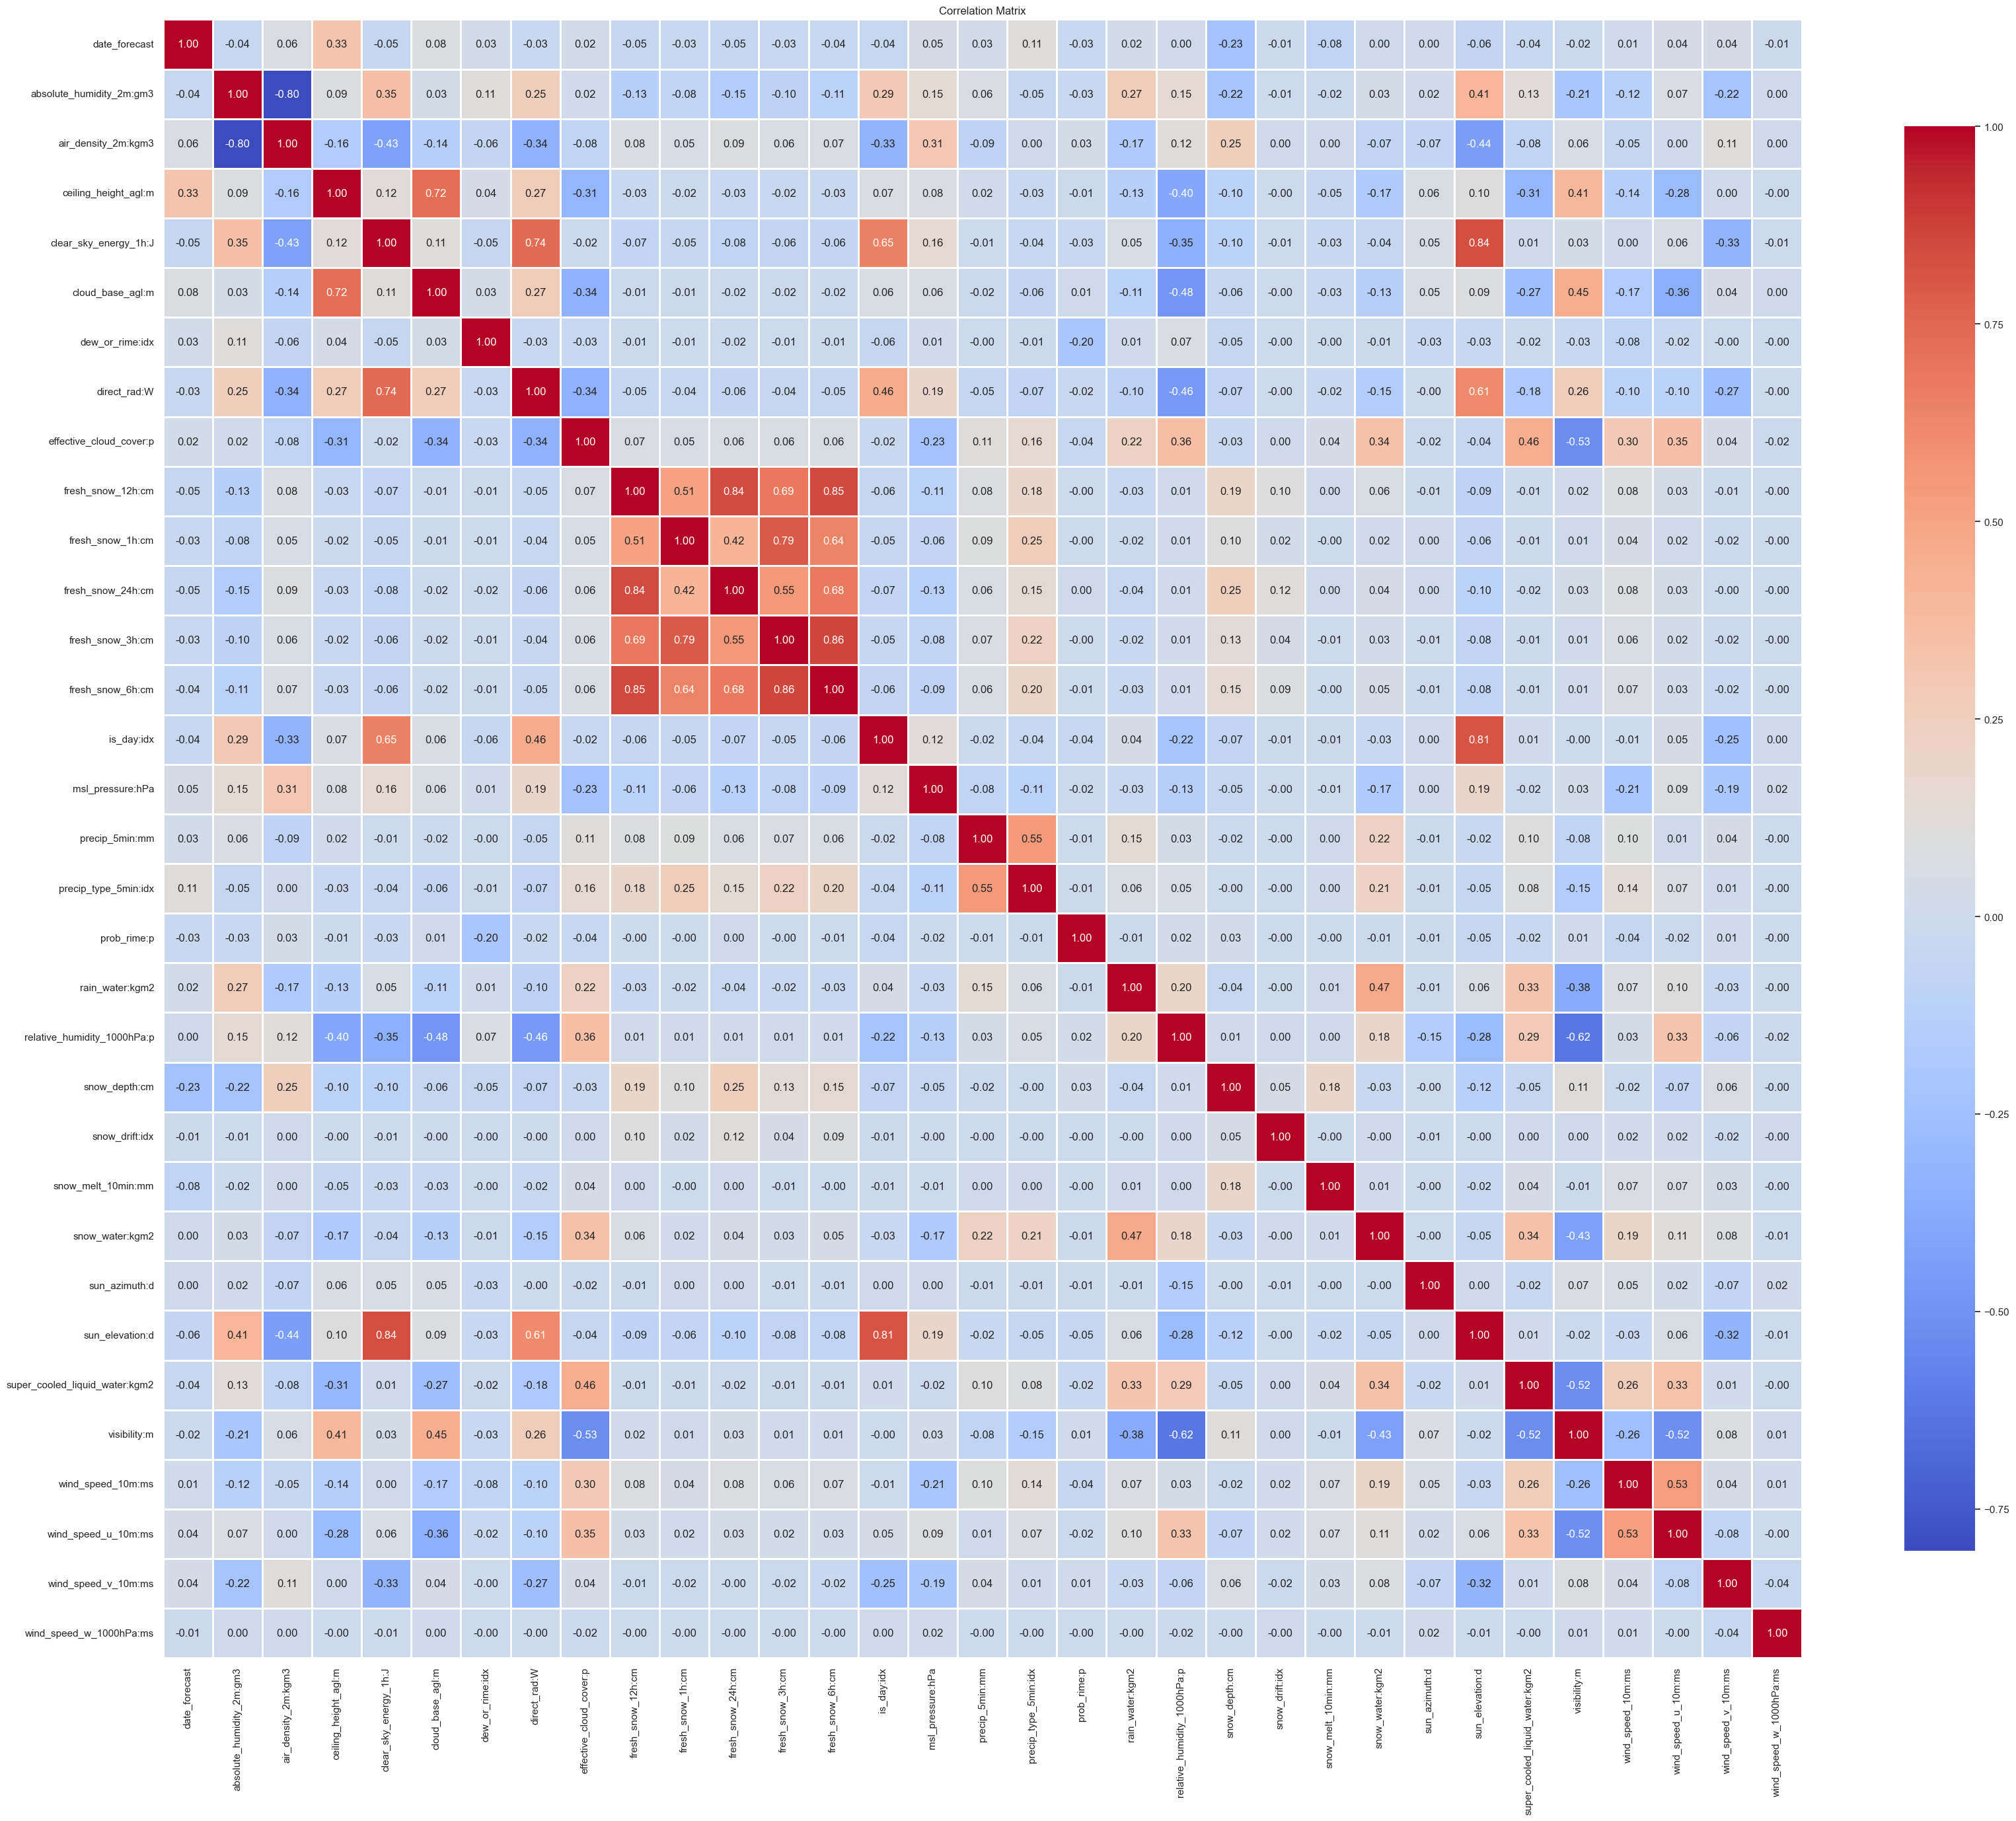

In [17]:
features = find_low_correlation_columns(X_train_observed,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = list(features)

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

There are still `NaN` values in the data (both features and target data) that we need to replace.

In [7]:
location = 'C'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
Missing data in pv_measurement  size  6060  out of 32155
Filled with bfill method
** WORKING ON X_train_observed**


C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='bfill')


Missing data in ceiling_height_agl:m  size  19923  out of 116825
Filled with ffill method
Missing data in cloud_base_agl:m  size  8512  out of 116825
Filled with ffill method
** WORKING ON X_train_estimated**
Missing data in ceiling_height_agl:m  size  4596  out of 17576
Filled with ffill method
Missing data in cloud_base_agl:m  size  2804  out of 17576
Filled with ffill method
** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl:m  size  849  out of 2880
Filled with bfill method
Missing data in cloud_base_agl:m  size  375  out of 2880
Filled with ffill method


In [20]:
YData = train_target
XTrain = pd.concat([x_df])[FEATURES[1]]

# Make sure that the dates are in the correct order
YData.sort_values(by="time", inplace=True)
XTrain.sort_values(by="date_forecast", inplace=True)

# Now, we have to interpolate YData_selected to match the time interval of XData_selected
# First, ensure "time" column in YData_selected is in datetime format
YData['time'] = pd.to_datetime(YData['time'])
YData.set_index('time', inplace=True)
# Resample with a 15 minute time interval
YData_resampled = YData.resample('15T').interpolate(method='nearest') #  use 'linear' for better interpolation
YData_resampled = YData_resampled.reset_index()



# Extract the start and end dates from YData
start_date_Y = YData_resampled["time"].min()
end_date_Y = YData_resampled["time"].max()

# Extract the start and end dates from XData
start_date_X = XTrain["date_forecast"].min()
end_date_X = XTrain["date_forecast"].max()

# Only select dates where we have data for X and Y
start_date = max(start_date_Y,start_date_X)
end_date = min(end_date_Y,end_date_X)

# Select XData within the specified date range
XData_selected = XTrain[(XTrain["date_forecast"] >= start_date) & (XTrain["date_forecast"] <= end_date)]
YData_selected = YData_resampled[(YData_resampled["time"] >= start_date) & (YData_resampled["time"] <= end_date)]

XData_selected = XData_selected.drop(columns='date_forecast')
YData_selected = YData_selected['pv_measurement']

# Replace colons in the feature names
XData_selected.columns = [column.replace(":","_") for column in XData_selected.columns]

We can now train the light gbm model

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [21]:
# Split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(XData_selected,YData_selected,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)


In [31]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=1000)

# Make Y_pred
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4182
[LightGBM] [Info] Number of data points in the train set: 94935, number of used features: 30
[LightGBM] [Info] Start training from score 674.676429
Mean Squared Error: 48957


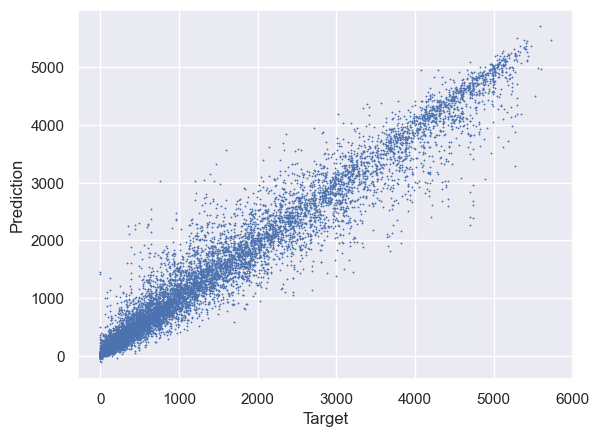

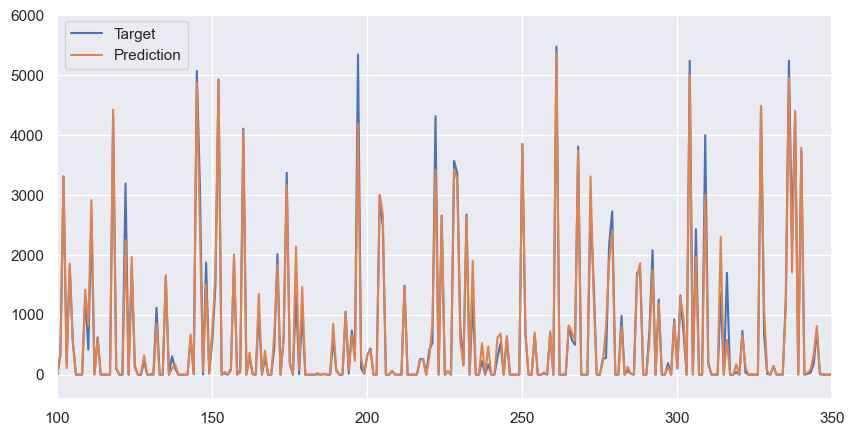

In [35]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

This model is pretty dumb as there is no time awareness (using previous data), it is just regression on a vector. Also, we are only training using the observed data and not the forecasted one so it's not quite what we wanted. We will now use a sliding window

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Define your sliding window configuration
window_size = 4*1000  # The past 1000 hours
step_size = 4*500     # Move 500 hours forward

# Create TimeSeriesSplit with sliding window
tscv = TimeSeriesSplit(n_splits=(len(XData_selected) - window_size) // step_size + 1)

mse_scores = []

for train_index, test_index in tscv.split(XData_selected):
    # Extract the current window for training and testing
    train_indices = range(train_index[0], train_index[-1] + 1)
    test_indices = range(test_index[0], test_index[-1] + 1)

    X_train = XData_selected.iloc[train_indices]
    X_test = XData_selected.iloc[test_indices]
    Y_train = YData_selected.iloc[train_indices]
    Y_test = YData_selected.iloc[test_indices]

    # Convert data to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_test, label=Y_test)

    # Set LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "mse",
        "num_leaves": 500,
        "learning_rate": 0.05,
    }

    # Train the LightGBM model
    model = lgb.train(params, train_data, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Evaluate the model
    mse = mean_squared_error(Y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean MSE across all sliding windows
mean_mse = sum(mse_scores) / len(mse_scores)
print(f"Mean Squared Error (across sliding windows): {mean_mse:.0f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 2031, number of used features: 22
[LightGBM] [Info] Start training from score 1153.849845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
y_pred = model.predict(XData_selected, num_iteration=model.best_iteration)

plt.figure()
plt.scatter(YData_selected,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

This is slower and has a higher MSE, not very good.

---
## Clean data loader
Here we try to implement a cleaner version of the dataset loader.  There is a function that does all this in one single execution below. This section is mostly for explanation purposes

First we load the data and fill the `NaN` values for the selected location. We also get the low correlation features from the different datasets.

In [16]:
LOCATION = 'C'

# load datasets, clean the NaNs and get low correlation features
train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(LOCATION, 0.9,verbose=False)

Now we can process the datasets to select only time points where there is data in both the training and the target values.

In [17]:
Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)

X_Train,Y_Train = select_and_resample(Xdf,Ydf)

We cannot use the `date_forecast` and `date_calc` columns because they are of type `DateTime`. We need to convert them to a value that the models will be able to use (while keeping the periodicity). This is done in the function below that adds the following features:

- `sin_day` a sine wave where -1 corresponds to midnight
- `sin_year` a sine wave where -1 corresponds to January 1st
- `forecast_interval` the time in seconds between the time when the prediction was made and the day of the prediction

In [18]:
X_Train = convert_datetime(X_Train,'date_forecast')
X_Test = convert_datetime(X_test_estimated, 'date_forecast')

### Plots

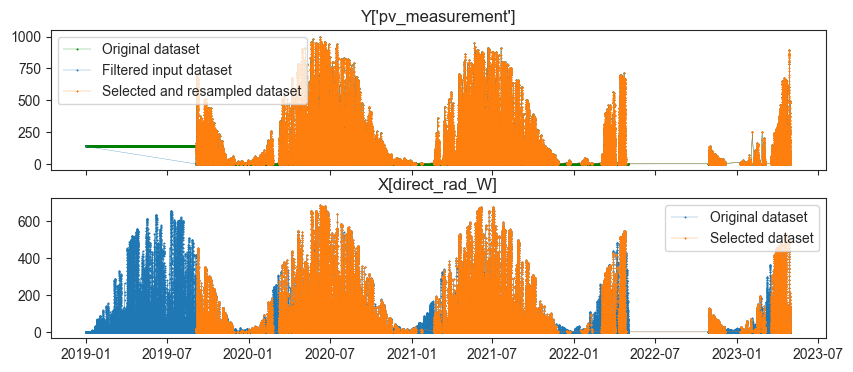

Before processing 
Y : (10600, 2)
X : (134401, 48)

After processing 
Y : (42360, 2)
X : (42360, 51)


In [19]:
# plot the difference between the original dataset and the filtered one
fig, axs = plt.subplots(figsize=(10,4), ncols=1, nrows=2, sharex=True)
axs[0].plot(train_target['time'],train_target['pv_measurement'],'-*g',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[0].plot(Ydf['time'],Ydf['pv_measurement'],'-*',linewidth = 0.2, markersize = 0.8, label="Filtered input dataset")
axs[0].plot(Y_Train['time'],Y_Train['pv_measurement'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected and resampled dataset")
axs[0].set_title("Y['pv_measurement']")
axs[0].legend()
axs[1].plot(Xdf['date_forecast'],Xdf['direct_rad_W'],'-*',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[1].plot(X_Train['date_forecast'],X_Train['direct_rad_W'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected dataset")
axs[1].set_title("X[direct_rad_W]")
axs[1].legend()

#plt.xlim([pd.Timestamp('2021-01-01'),pd.Timestamp('2021-02-01')])
plt.show()
fig.tight_layout()

print(f"Before processing \nY : {np.shape(Ydf)}\nX : {np.shape(Xdf)}\n")
print(f"After processing \nY : {np.shape(Y_Train)}\nX : {np.shape(X_Train)}")

Plot the added features for the `DateTime` columns encoding

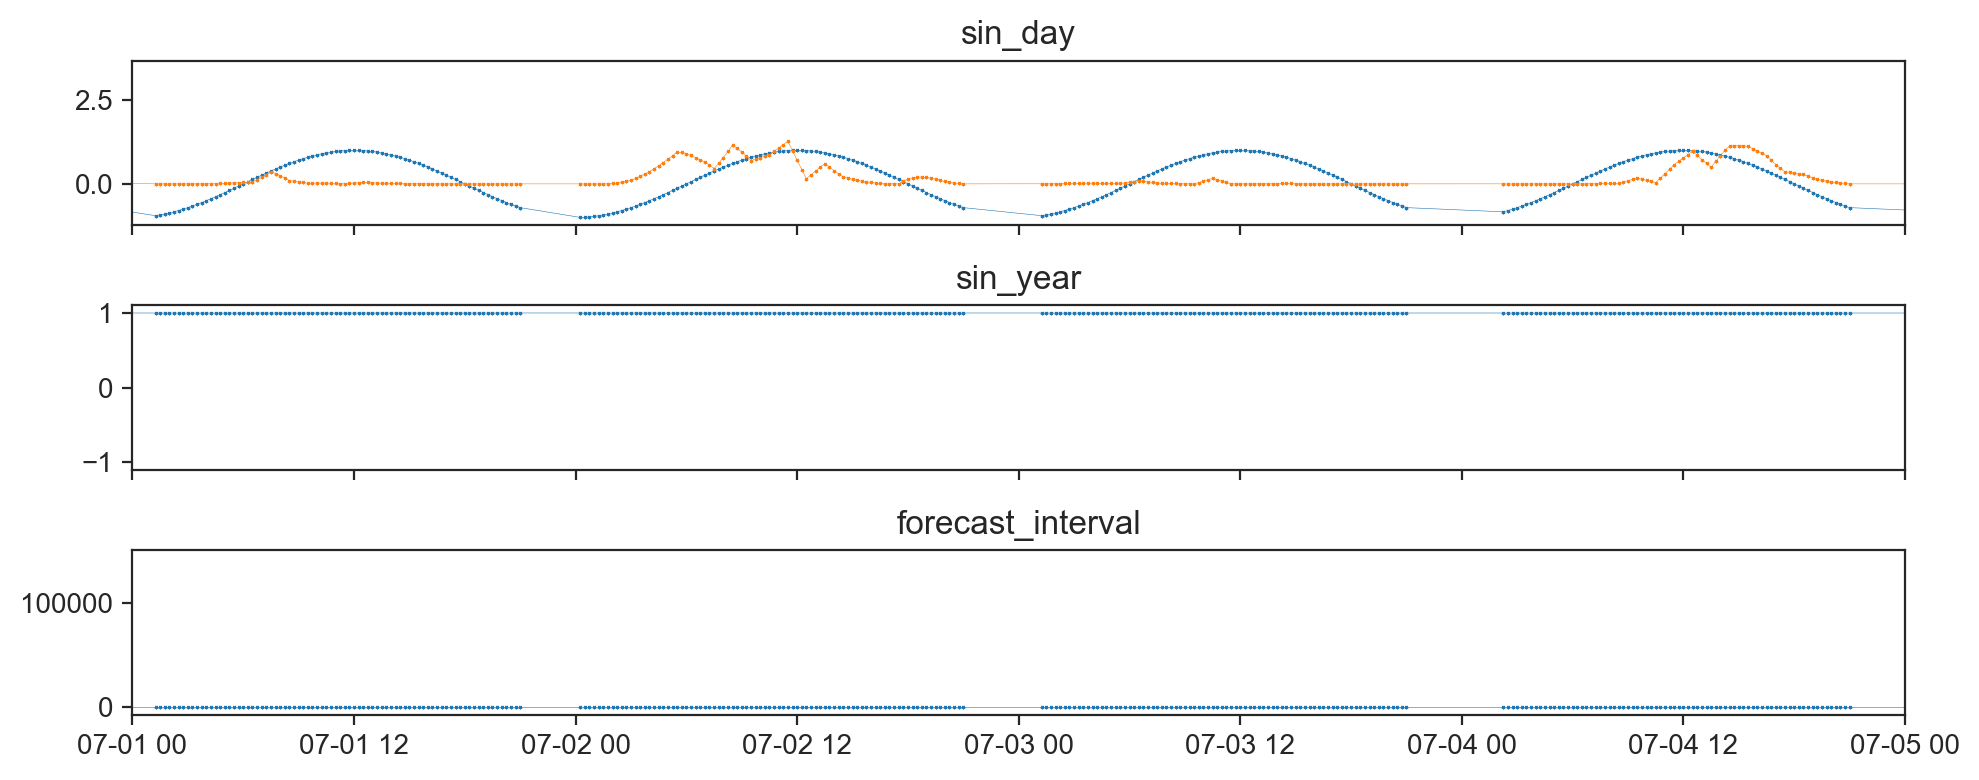

In [59]:
fig, axs = plt.subplots(figsize=(10,4), ncols=1, nrows=3, sharex=True, dpi=200)
axs[0].plot(X_Train['date_forecast'],X_Train['sin_day'],'-*',linewidth = 0.2, markersize = 0.8)
axs[0].plot(X_Train['date_forecast'],X_Train['direct_rad_W']/200,'-*',linewidth = 0.2, markersize = 0.8)
axs[0].set_title("sin_day")
axs[0].set_xlim(pd.to_datetime(['2019-07-01', '2019-07-05']))
axs[1].plot(X_Train['date_forecast'],X_Train['sin_year'],'-*',linewidth = 0.2, markersize = 0.8)
axs[1].set_title("sin_year")
axs[2].plot(X_Train['date_forecast'],X_Train['forecast_interval'],'-*',linewidth = 0.2, markersize = 0.8)
axs[2].set_title("forecast_interval")
fig.tight_layout()
plt.show()

It is now interesting to plot some statistics of the training target :

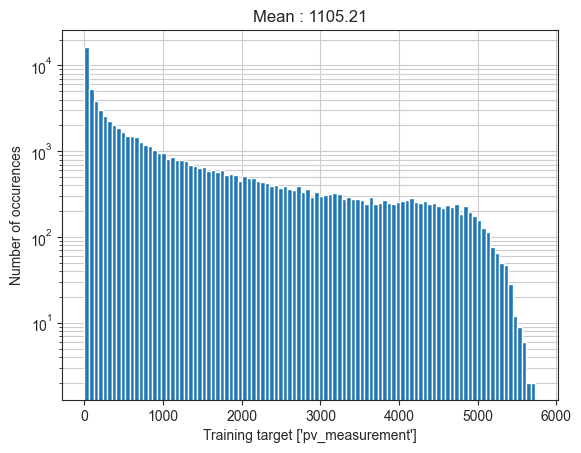

In [96]:
plt.figure()
plt.hist(Y_Train['pv_measurement'], bins=100)
plt.xlabel("Training target ['pv_measurement']")
plt.ylabel("Number of occurences")
plt.title(f"Mean : {Y_Train['pv_measurement'].mean():.2f}")
plt.yscale('log')
plt.grid(which='both')
plt.show()

There is a lot of 0

### Lagged features

The implementation above oversamples the target data to match the X data. The training is done as a simple regression from weather features (vector) at time $t$ to power output (scalar) at time $t$. We want to implement lagged features so that the prediction at time $t$ will use the features at times $\{t,t-15,t-30,t-45\}$

In [239]:
n_lagged_features = 0
time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
X_Train_lagged = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
X_test_lagged = lagged_features(X_Test,time_intervals=time_lags,verbose=False)

print(X_Train.shape)
print(X_Train_lagged.shape)
print(X_test_estimated.shape)
print(X_test_lagged.shape)

### Plots

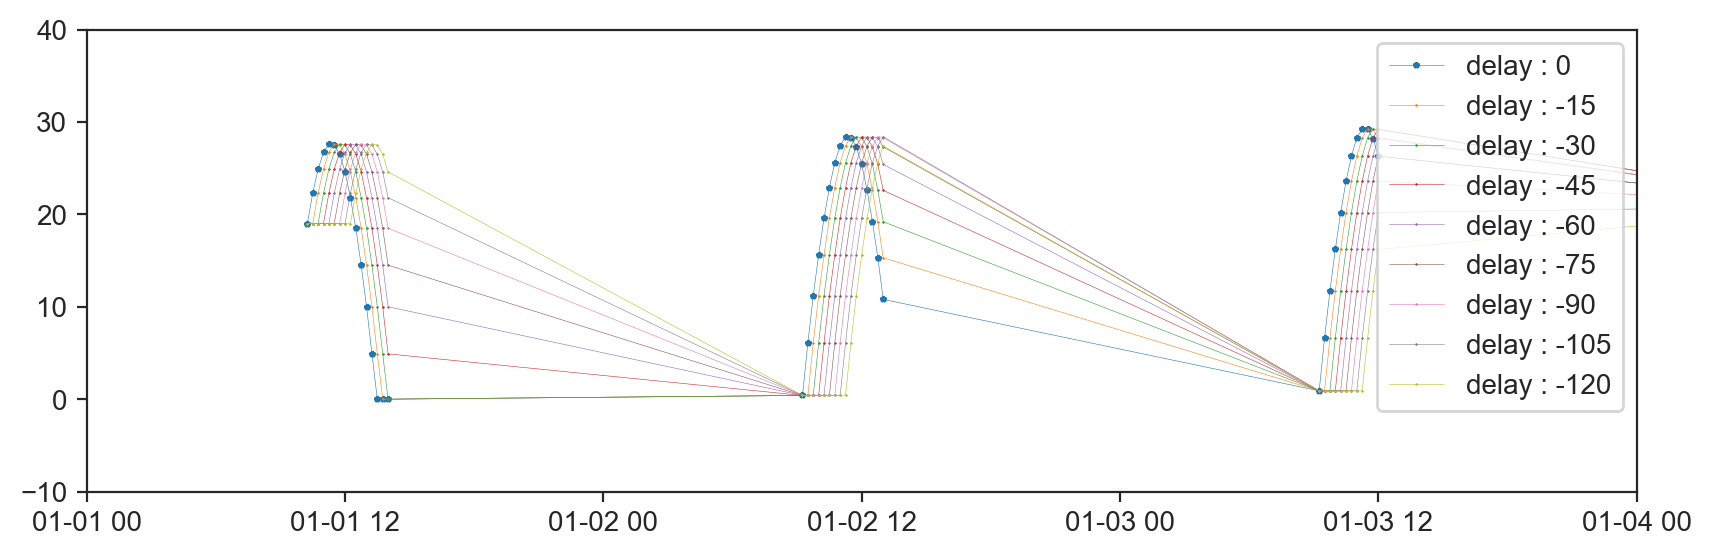

date_forecast  absolute_humidity_2m_gm3  air_density_2m_kgm3  \
1  2019-01-01 10:15:00                       5.7                1.250   
2  2019-01-01 10:30:00                       5.7                1.251   
3  2019-01-01 10:45:00                       5.7                1.253   
4  2019-01-01 11:00:00                       5.6                1.254   
5  2019-01-01 11:15:00                       5.6                1.254   
6  2019-01-01 11:30:00                       5.6                1.254   
7  2019-01-01 11:45:00                       5.5                1.254   
8  2019-01-01 12:00:00                       5.5                1.254   
9  2019-01-01 12:15:00                       5.5                1.256   
10 2019-01-01 12:30:00                       5.4                1.258   

    ceiling_height_agl_m  clear_sky_energy_1h_J  clear_sky_rad_W  \
1            1815.800049           37181.800781        19.000000   
2            1896.500000           53178.000000        22.299999   
3            1977.400024           67014.398438        24.900000   
4            2058.199951           78608.500000        26.700001   
5            2139.100098           87704.898438        27.600000   
6            2219.300049           93948.296875        27.500000   
7            2297.399902           97027.601562        26.500000   
8            2375.800049           96774.101562        24.600000   
9            2408.600098           93202.000000        21.799999   
10           2441.300049           86505.203125        18.500000   

    cloud_base_agl_m  dew_or_rime_idx  dew_point_2m_K  diffuse_rad_W  \
1        1815.800049              0.0      275.600006            3.3   
2        1896.500000              0.0      275.600006            3.5   
3        1977.400024              0.0      275.500000            4.1   
4        2058.199951              0.0      275.399994            4.7   
5        2139.100098              0.0      275.399994            5.2   
6        2219.300049              0.0      275.299988            5.5   
7        2297.399902              0.0      275.200012            6.6   
8        2375.800049              0.0      275.200012            7.3   
9        2408.600098              0.0      275.000000            7.6   
10       2441.300049              0.0      274.799988            7.4   

    diffuse_rad_1h_J  direct_rad_W  direct_rad_1h_J  effective_cloud_cover_p  \
1        5889.799805           0.0        31.900000                99.800003   
2        8516.599609           0.0        49.900002                99.900002   
3       11413.200195           0.0        41.799999                99.900002   
4       13648.299805           0.0        46.799999                99.900002   
5       15218.299805           0.0        47.299999                99.599998   
6       16093.000000           0.0        49.900002                98.900002   
7       19320.099609           0.1       169.600006                97.900002   
8       21721.800781           0.1       266.799988                96.599998   
9       23041.800781           0.2       331.500000                96.199997   
10      23088.599609           0.2       356.200012                96.199997   

    elevation_m  fresh_snow_12h_cm  fresh_snow_1h_cm  fresh_snow_24h_cm  \
1           7.0                0.0               0.0                0.0   
2           7.0                0.0               0.0                0.0   
3           7.0                0.0               0.0                0.0   
4           7.0                0.0               0.0                0.0   
5           7.0                0.0               0.0                0.0   
6           7.0                0.0               0.0                0.0   
7           7.0                0.0               0.0                0.0   
8           7.0                0.0               0.0                0.0   
9           7.0                0.0               0.0                0.0   
10          7.0                0

In [222]:
featurename = 'clear_sky_rad_W'

plt.figure(dpi=200,figsize=(10,3))
plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename],'-*',linewidth=0.2,markersize=2,label='delay : 0')
for delay in time_lags:
    plt.plot(X_Train_lagged['date_forecast'],X_Train_lagged[featurename+f"__r{delay}"],'-*',linewidth=0.2,markersize=0.2,label=f"delay : -{delay}")
plt.legend()
plt.xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2019-01-04')])
plt.ylim([-10,40])
plt.show()

X_Train_lagged.head(10)

It is a bit trash because i could not find a way to fill the values that were not in the dataset with copy of the last known values so there are quite a few instances where the lagged features do not correspond to the data that was 15 minutes ago.


---
## Full data loader
This is a single function that performs all the data pre-processing

In [9]:
LOCATION = "B"
n_lagged_features = 1
threshold = 0.9

X_Train_full,Y_Train,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'minmax',
                                                        date_encoding=True,
                                                        verbose=True)
print(f"{len(selected_features)} features selected\n")
# print(selected_features)

Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with minmax

Done

68 features selected



---
## Train models

I dont know how to do cross validation help

In [10]:
# Select the correct columns for the prediction
X_Train = X_Train_full[selected_features].astype('float32')
X_Test = X_Test_full[selected_features].astype('float32')

# Note : the lagged features code is a bit too extreme, a lot of unnecessary features so increased complexity for nothing

RANDOM_SEED = 59

In [11]:
# Split training data into train, validation and test 
from sklearn.model_selection import train_test_split
# Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(X_Train,Y_Train,
                                                    test_size=0.1,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)
# Train/Validation
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,
                                               test_size=0.1,
                                               random_state=RANDOM_SEED,
                                               shuffle=True)

### LGB regression

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [16]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
    "num_threads" : 2,
}

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 33888, number of used features: 32
[LightGBM] [Info] Start training from score 187.665394


In [17]:
# Make predictions
Y_pred = np.asarray(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.0f}")

Mean Squared Error: 867


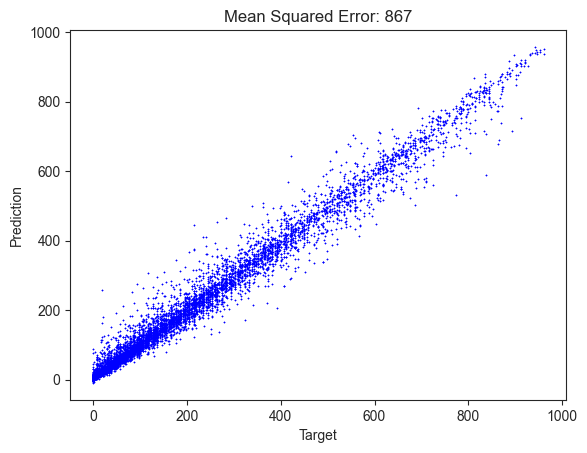

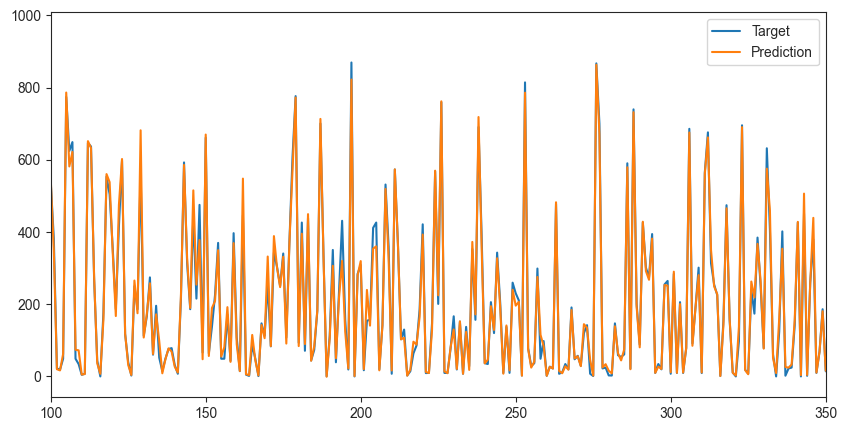

In [18]:
plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Mean Squared Error: {mse:.0f}")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,Y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

### CatBoost regression

In [6]:
from catboost import CatBoostRegressor,Pool
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from catboost.utils import get_gpu_device_count
print('Detected GPU devices : %i' % get_gpu_device_count())

Detected GPU devices : 1


Attempts at time series split for cross validation


 12973 points in the training data
0:	learn: 1046.0581800	test: 1182.0866330	best: 1182.0866330 (0)	total: 446ms	remaining: 7m 25s
100:	learn: 100.9328583	test: 753.4050291	best: 734.1034629 (18)	total: 25.7s	remaining: 3m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 734.1034629
bestIteration = 18

Shrink model to first 19 iterations.

 25944 points in the training data
0:	learn: 1099.6046722	test: 1031.5285432	best: 1031.5285432 (0)	total: 304ms	remaining: 5m 3s
100:	learn: 171.2791078	test: 584.4683578	best: 570.2435784 (31)	total: 26.5s	remaining: 3m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 570.2435784
bestIteration = 31

Shrink model to first 32 iterations.

 38915 points in the training data
0:	learn: 1071.3939127	test: 1207.1934399	best: 1207.1934399 (0)	total: 348ms	remaining: 5m 47s
100:	learn: 200.1286275	test: 626.7187662	best: 622.4319086 (44)	total: 30.1s	remaining: 4m 28s
Stopped by overfitting detector  (100 iterati

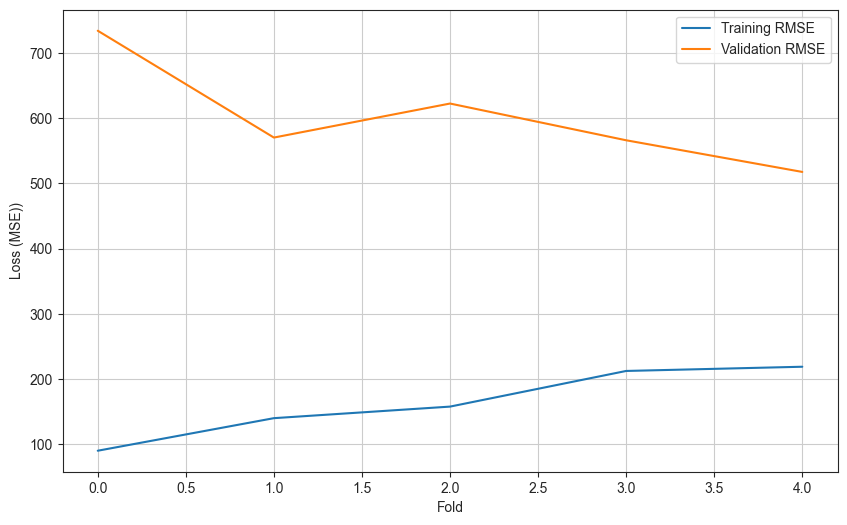

In [7]:
# Set the hyperparameters for the CatBoostRegressor:
iterations = 1000        # Number of boosting iterations
learning_rate = 0.25     # Learning rate
depth = 11               # Depth of trees
l2_leaf_reg=4            # l2 regularisation factor

# Initialize the TimeSeriesSplit:
n_splits = 5  # Number of time series splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create a list to store training and validation RMSE for each fold
train_mae_list = []
val_mae_list = []

for train_index, test_index in tscv.split(X_Train):
    X_train_fold, X_test_fold = X_Train.iloc[train_index], X_Train.iloc[test_index]
    y_train_fold, y_test_fold = Y_Train.iloc[train_index], Y_Train.iloc[test_index]

    print(f"\n {len(y_train_fold)} points in the training data")

    # Create CatBoost Pools for training and validation data
    train_pool = Pool(data=X_train_fold, label=y_train_fold)
    val_pool = Pool(data=X_test_fold, label=y_test_fold)

    # Create a new instance of the CatBoostRegressor for each fold
    model = CatBoostRegressor(iterations=iterations,
                              learning_rate=learning_rate,
                              depth=depth,
                              l2_leaf_reg=l2_leaf_reg,
                            #   random_strength = 10,
                              loss_function='RMSE',
                              custom_metric='RMSE',
                            #   task_type='GPU',
                            #   devices='0',
                              verbose=100)

    # Train the model with validation data and monitor MAE
    model.fit(train_pool,
              eval_set=val_pool,
              use_best_model=True,
              early_stopping_rounds=100)

    # Get training and validation MAE values
    train_rmse = model.get_best_score()['learn']['RMSE']
    val_rmse = model.get_best_score()['validation']['RMSE']

    # Append MAE values to the lists
    train_mae_list.append(train_rmse)
    val_mae_list.append(val_rmse)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_mae_list, label='Training RMSE')
plt.plot(val_mae_list, label='Validation RMSE')
plt.xlabel('Fold')
plt.ylabel('Loss (MSE))')
# plt.title('')
plt.legend()
plt.grid(True)
plt.show()

Train the model

In [17]:
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=10,
                          learning_rate=0.2,
                          l2_leaf_reg=10,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)


history = catboost_model.fit(X_train, Y_train,
                            use_best_model = True,
                            eval_set=(X_val,Y_val),
                            early_stopping_rounds=50)

0:	learn: 177.0776686	test: 176.5113450	best: 176.5113450 (0)	total: 436ms	remaining: 21m 48s
100:	learn: 53.4354550	test: 56.7580202	best: 56.7580202 (100)	total: 24.5s	remaining: 11m 43s
200:	learn: 41.5275714	test: 47.1958717	best: 47.1958717 (200)	total: 48.5s	remaining: 11m 14s
300:	learn: 37.6907709	test: 43.9870847	best: 43.9870847 (300)	total: 1m 11s	remaining: 10m 44s
400:	learn: 33.9514575	test: 40.8151051	best: 40.8151051 (400)	total: 1m 35s	remaining: 10m 19s
500:	learn: 30.7426882	test: 38.1892296	best: 38.1892296 (500)	total: 1m 59s	remaining: 9m 55s
600:	learn: 28.6517869	test: 36.3304796	best: 36.3304796 (600)	total: 2m 22s	remaining: 9m 30s
700:	learn: 26.6036521	test: 34.5418252	best: 34.5418252 (700)	total: 2m 46s	remaining: 9m 7s
800:	learn: 25.6418159	test: 33.7947283	best: 33.7947283 (800)	total: 3m 10s	remaining: 8m 42s
900:	learn: 24.6046742	test: 32.9128900	best: 32.9128900 (900)	total: 3m 33s	remaining: 8m 18s
1000:	learn: 23.9196044	test: 32.3772238	best: 32.

Test the model

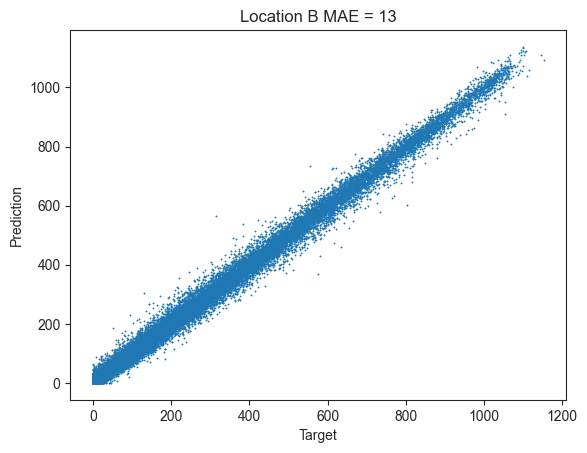

In [12]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_lag1_minmax.cbm",format='cbm')

# Make predictions every 15 minutes
Y_pred = catboost_model.predict(X_train)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_train, Y_pred)

plt.figure()
plt.scatter(Y_train,Y_pred,s=0.05,marker="*",)
#plt.scatter(Y_test_hour['pv_measurement'],Y_pred_hour['pv_measurement'],s=0.05,c="r",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.0f}")
plt.show()

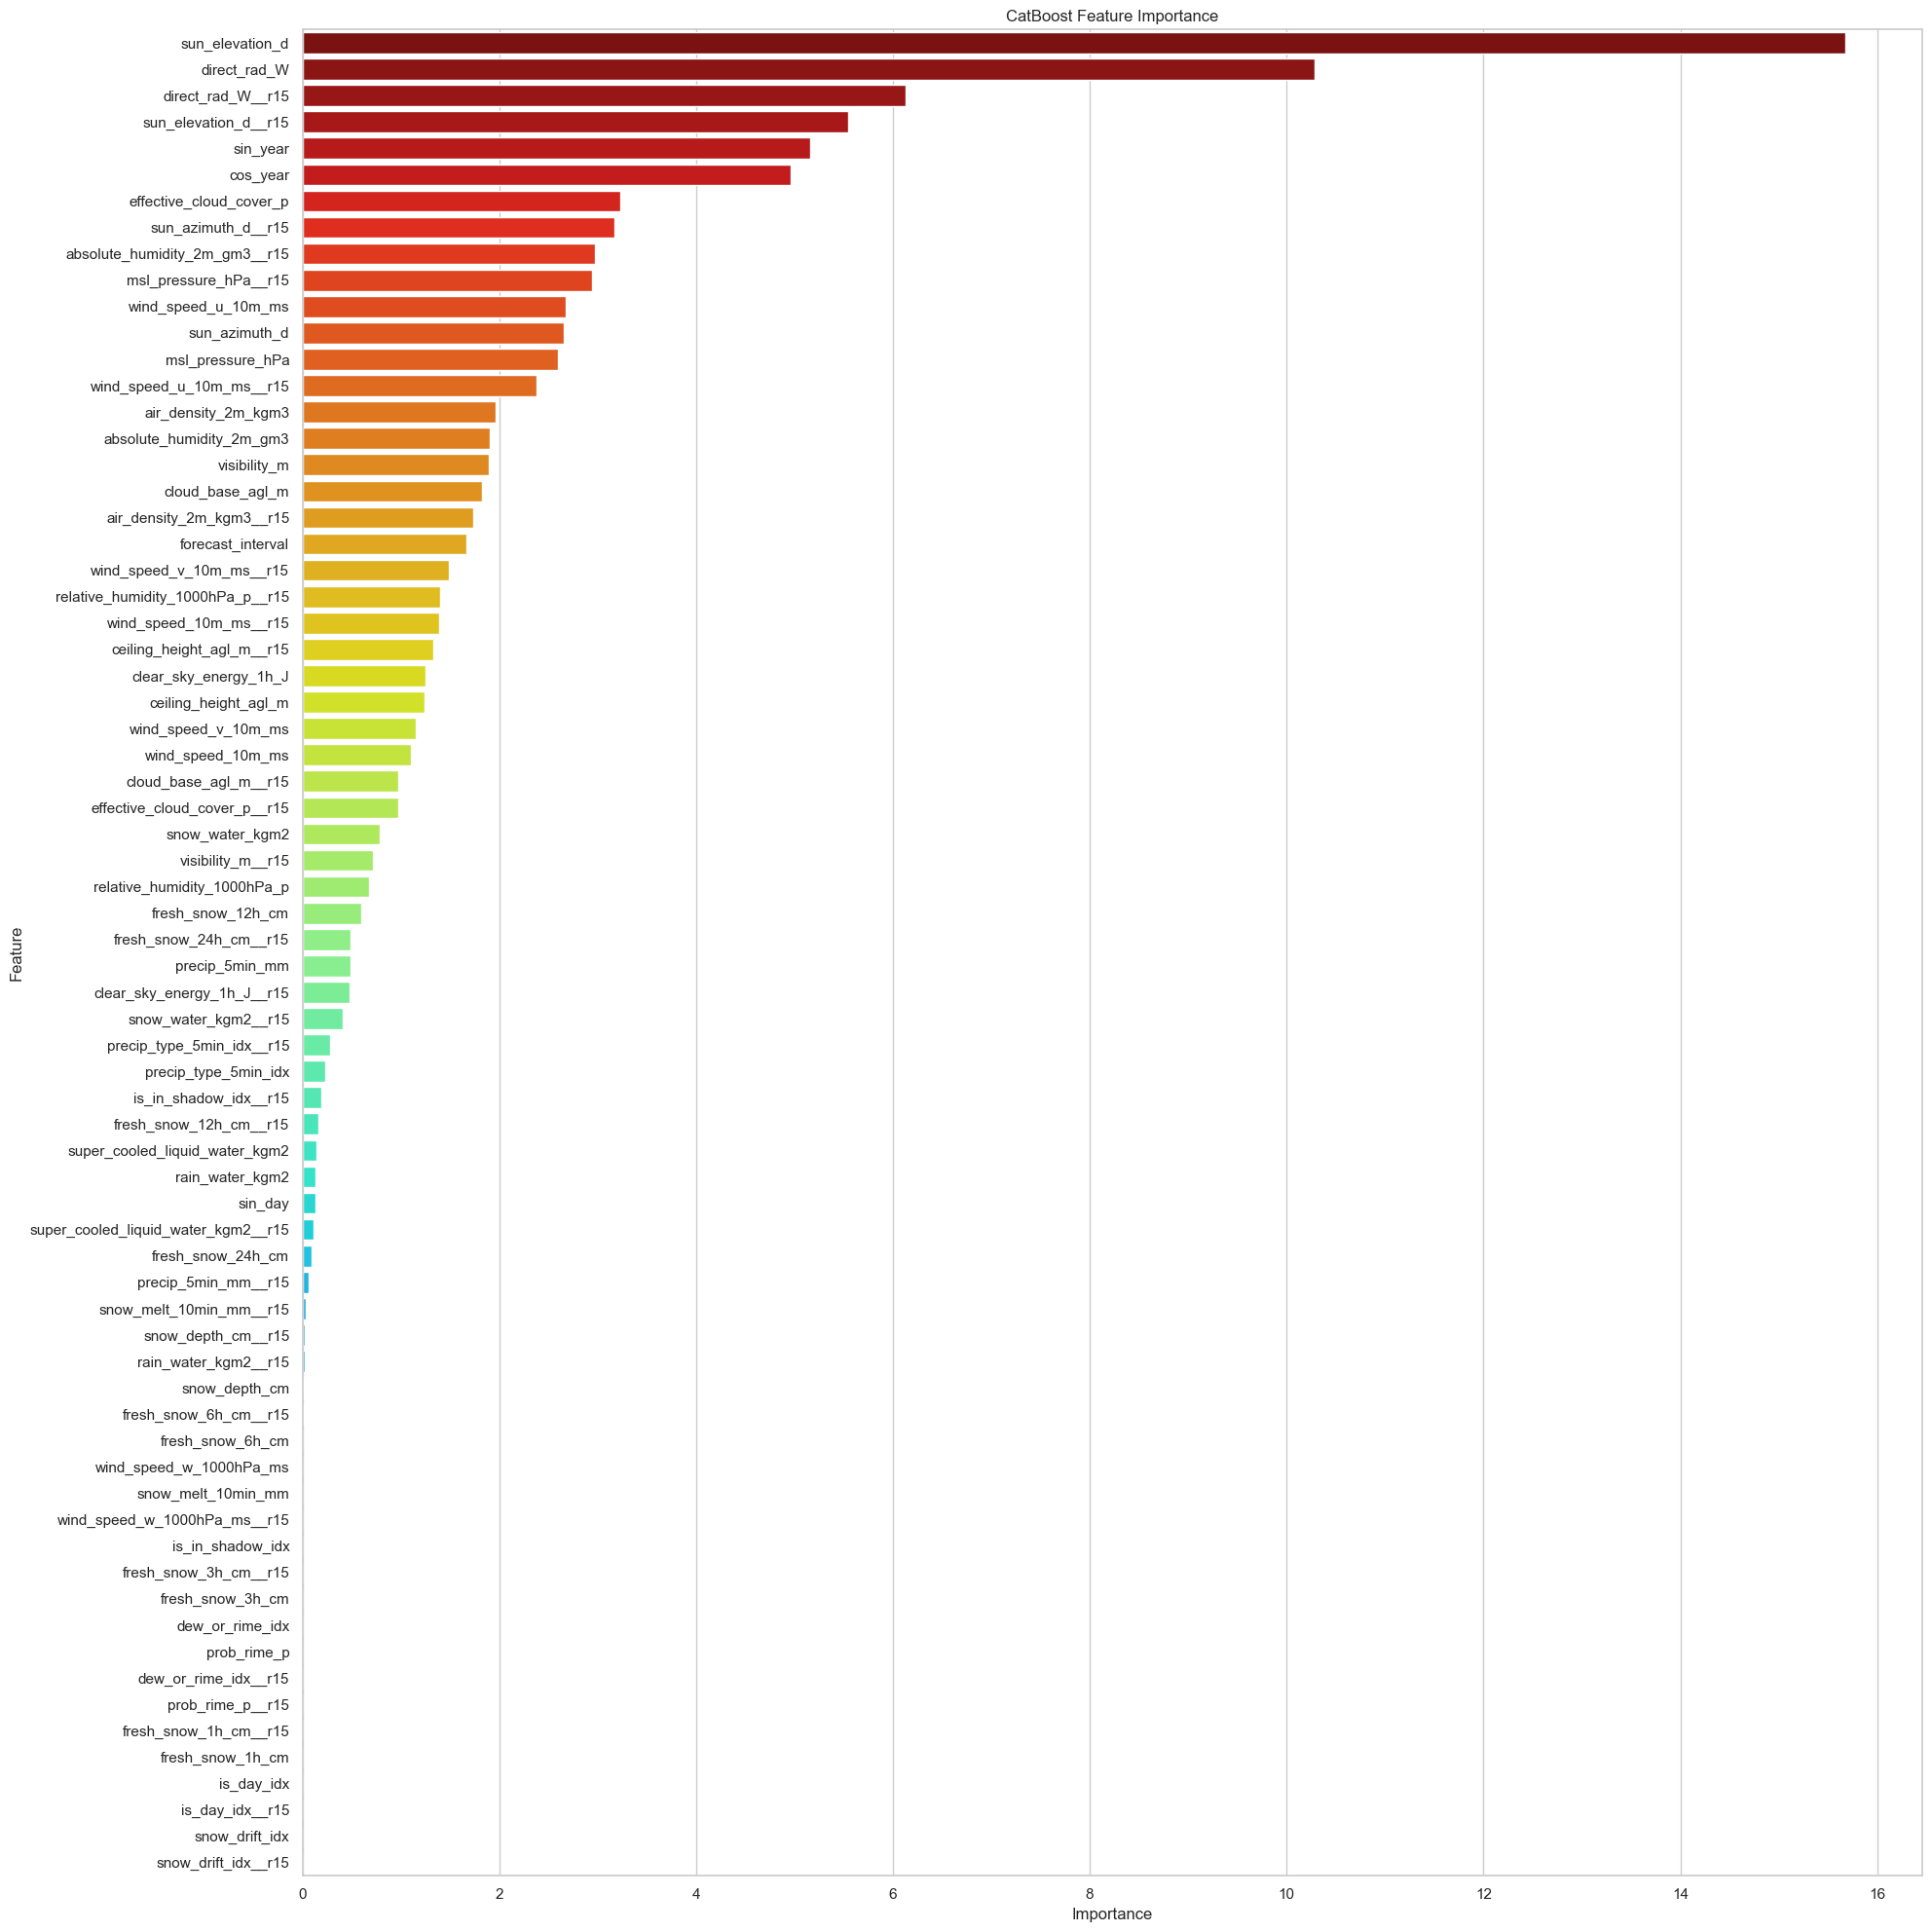

In [19]:
feature_importances = catboost_model.get_feature_importance()
feature_names = X_Train.columns  # If your features are in a DataFrame

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(20, 20),dpi=100)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="jet_r", hue='Feature',width=0.8,gap=2,dodge='auto')

# Customize the plot
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()

Using a randomized search for the hyper parameters of the catboost regressor.

**WARNING : this is very long (~60+ minutes)** 

In [ ]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.1,0.15, 0.20,0.25,0.30,0.35,0.40,0.45],
        'depth': [4,5,6,7,9,10,11,12,13],
        'l2_leaf_reg': [4,5,6,7,8,9,10]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X_Train,
                                                   y=Y_Train,
                                                   plot=True,
                                                   verbose=False,
                                                   n_iter=20)

In [52]:
# save model A

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=11,
                          learning_rate=0.25,
                          l2_leaf_reg=4,
                          loss_function='RMSE',
                          verbose=100)
"""

catboostA = catboost_model
catboostA.save_model('CatBoost_models/CatBoostA_lag1_minmax.cbm',format='cbm')

In [12]:
# save model B

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=11,
                          learning_rate=0.25,
                          l2_leaf_reg=7,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)
"""

catboostB = catboost_model
catboostB.save_model('CatBoost_models/CatBoostB_lag1_minmax.cbm',format='cbm')

In [20]:
# save model C

# training data :
"""
catboost_model = CatBoostRegressor(iterations=3000,
                          depth=12,
                          learning_rate=0.20,
                          l2_leaf_reg=11,
                          loss_function='RMSE',
                          task_type='GPU',
                          devices='0',
                          verbose=100)
"""

catboostC = catboost_model
catboostC.save_model('CatBoost_models/CatBoostC_lag1_minmax.cbm',format='cbm')

We can try to train again using only the top 20 feature for example and see if it leads to better results

I did it and it was not convincing.

### MLP regression

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense,Input,Dropout
from sklearn.metrics import mean_absolute_error

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this line to use GPU

In [6]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, allow memory growth and select a GPU device
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU devices found. Using CPU.")

Physical GPUs: 1, Logical GPUs: 1


In [7]:
# Define hyperparameters and model architecture
input_shape = X_Train.shape[1]  # Shape of input data (number of features)
output_shape = 1                # Shape of output data (scalar)

In [8]:
# Define model architecure
def create_mlp(input_shape,output_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape)))
    model.add(Dense(input_shape, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))    # Input layer
    model.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model.add(Dense(512, activation='relu'))            # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(256, activation='relu'))            # Hidden layer
    model.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(64, activation='relu'))             # Hidden layer
    model.add(Dropout(0.2))                             # 20% dropout layer
    model.add(Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))             # Hidden layer
    model.add(Dense(output_shape, activation='linear')) # Output layer
    
    # model.summary()
    return model

# Define a function to schedule the learning rate
def adaptive_learning_rate(epoch, lr):
    if epoch % 200 == 0 and epoch > 0:
        return lr / 2  # Divide the learning rate 
    else:
        return lr

In [9]:
# Cross validation
from sklearn.model_selection import TimeSeriesSplit, KFold

n_splits = 4
# K-folds
kf = KFold(n_splits=n_splits,shuffle=True,random_state=RANDOM_SEED)
# Time series split
tscv = TimeSeriesSplit(n_splits=n_splits)

In [10]:
# Training parameters
num_epochs = 200 
batch_size = 512  

fold_scores = []
learning_curves = []

# Perform cross-validation
for train_index, test_index in kf.split(X_Train):
    X_train_fold, X_val_fold = X_Train.iloc[train_index[:int(0.8*len(train_index))]], X_Train.iloc[train_index[int(0.8*len(train_index)):]]
    y_train_fold, y_val_fold = Y_Train.iloc[train_index[:int(0.8*len(train_index))]], Y_Train.iloc[train_index[int(0.8*len(train_index)):]]
    X_test_fold, y_test_fold = X_Train.iloc[test_index], Y_Train.iloc[test_index]

    # Create a new instance of your MLP model for each fold
    model = create_mlp(input_shape, output_shape)
    
    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(adaptive_learning_rate, verbose=1)
    

    # Compile and train the model for regression
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(X_train_fold,
                        y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        validation_freq=10,
                        epochs=num_epochs, 
                        batch_size=batch_size,
                        verbose=2,
                        callbacks=[lr_scheduler])
    
    learning_curves.append(history)
    
    # Evaluate the model on the test data and calculate the regression score
    test_predictions = model.predict(X_test_fold)
    mae = mean_absolute_error(y_test_fold, test_predictions)
    fold_scores.append(mae)

# Calculate and report the average MSE (or other regression score) across all folds
average_mae = np.mean(fold_scores)
print(f"\n\nAverage MAE:{average_mae:.2f}")
print(fold_scores)

epoch_number=np.arange(0,num_epochs)
print(epoch_number)
val_number = epoch_number[::10]+9
print(val_number)

fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=150)
for index,history in enumerate(learning_curves):
    ax[index].plot(epoch_number,history.history['mean_absolute_error'])
    ax[index].plot(val_number,history.history['val_mean_absolute_error'])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([5,num_epochs])
    ax[index].set_ylim([np.min(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])-20,
                        np.max(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])+20])
fig.tight_layout()
plt.show()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
92/92 - 4s - loss: 1397121.1250 - mean_absolute_error: 798.0779 - lr: 0.0010 - 4s/epoch - 39ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
92/92 - 1s - loss: 434237.6562 - mean_absolute_error: 421.6263 - lr: 0.0010 - 1s/epoch - 14ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
92/92 - 1s - loss: 394437.2188 - mean_absolute_error: 393.9363 - lr: 0.0010 - 1s/epoch - 13ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/200
92/92 - 1s - loss: 377366.8438 - mean_absolute_error: 382.7320 - lr: 0.0010 - 1s/epoch - 14ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/200
92/92 - 1s - loss: 369388.3125 - mean_absolute_error: 375.8152 - lr: 0.0010 - 1s/epoch - 15ms/step

Epoch 6: LearningRateScheduler setting lear

KeyboardInterrupt: 

Average MAE:327.09
[319.2965505696262, 314.1812191160568, 337.84693314664185, 337.0382992879098]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 9 19]


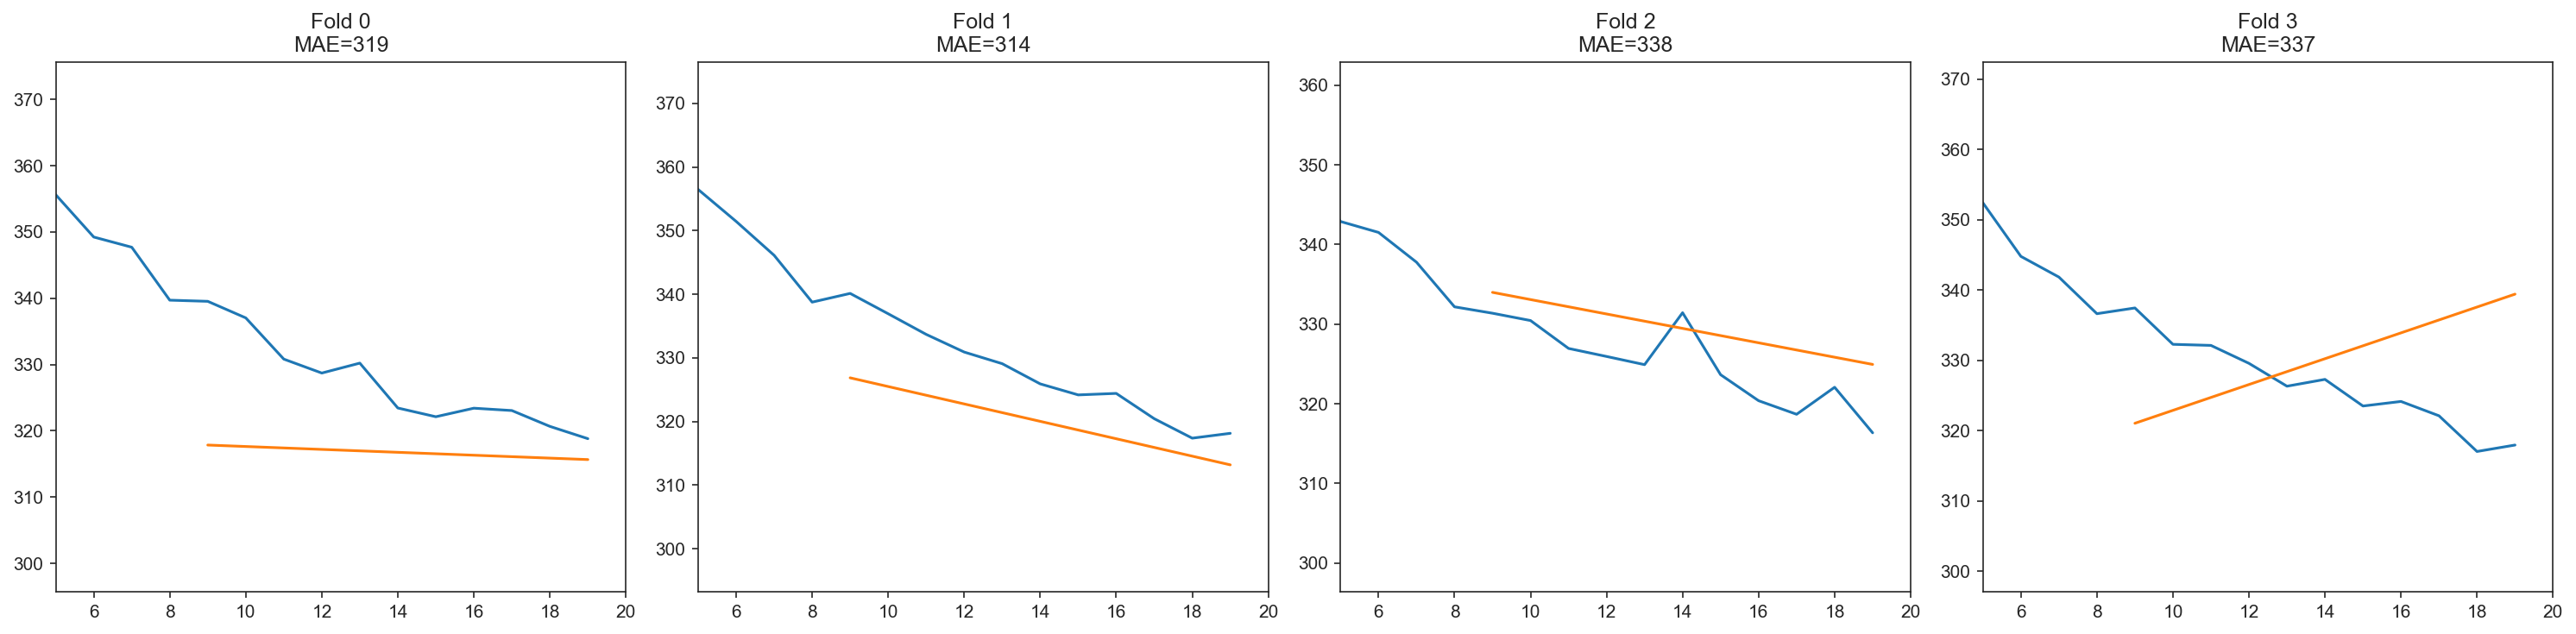

In [42]:
print(f"Average MAE:{average_mae:.2f}")
print(fold_scores)

epoch_number=np.arange(0,num_epochs)
print(epoch_number)
val_number = epoch_number[::10]+9
print(val_number)

fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=150)
for index,history in enumerate(learning_curves):
    ax[index].plot(epoch_number,history.history['mean_absolute_error'])
    ax[index].plot(val_number,history.history['val_mean_absolute_error'])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([5,num_epochs])
    ax[index].set_ylim([np.min(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])-20,
                        np.max(history.history['mean_absolute_error'][5:]+history.history['val_mean_absolute_error'][1:])+20])
fig.tight_layout()
plt.show()

In [26]:
print(learning_curves[2].history['val_mean_absolute_error'])

[333.99090576171875, 324.9442138671875]


In [22]:
# Calculate and report the average MSE (or other regression score) across all folds
average_mae = np.mean(fold_scores)
print("Average MAE:", average_mae)
print(fold_scores)

# fig,ax=plt.subplots(nrows=1,ncols=n_splits)
# for index,history in enumerate(learning_curves):
#     ax[index].plot(history.history['mean_absolute_error'][1:])
#     ax[index].plot(history.history['val_mean_absolute_error'][1:])
#     ax[index].set_title(f"Fold {index}: MAE={fold_scores[index]}")
# fig.tight_layout()
# plt.show()

Average MAE: 431.1534876743867
[604.5325082240581, 389.09788074908624, 399.7617225362448, 377.51626420755576, 384.85906265498846]


In [12]:
# Training parameters
num_epochs = 300  
batch_size = 512  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics = 'MeanAbsoluteError')

# Train the model
history = model.fit(X_train, Y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data=(X_val,Y_val),
          verbose=2)

Epoch 1/300
124/124 - 4s - loss: 18675778.0000 - mean_absolute_error: 1141.3351 - val_loss: 710556.5000 - val_mean_absolute_error: 570.0073 - 4s/epoch - 30ms/step
Epoch 2/300
124/124 - 1s - loss: 764279.3750 - mean_absolute_error: 570.3568 - val_loss: 985940.0000 - val_mean_absolute_error: 628.0126 - 1s/epoch - 11ms/step
Epoch 3/300
124/124 - 1s - loss: 678936.5625 - mean_absolute_error: 541.3748 - val_loss: 1141895.6250 - val_mean_absolute_error: 695.6910 - 1s/epoch - 12ms/step
Epoch 4/300
124/124 - 1s - loss: 782865.5000 - mean_absolute_error: 574.0361 - val_loss: 535043.0000 - val_mean_absolute_error: 484.0460 - 1s/epoch - 11ms/step
Epoch 5/300
124/124 - 1s - loss: 657984.6250 - mean_absolute_error: 532.7234 - val_loss: 965770.4375 - val_mean_absolute_error: 649.3272 - 1s/epoch - 11ms/step
Epoch 6/300
124/124 - 1s - loss: 596783.5000 - mean_absolute_error: 507.9417 - val_loss: 496333.1875 - val_mean_absolute_error: 467.0674 - 1s/epoch - 11ms/step
Epoch 7/300
124/124 - 1s - loss: 556

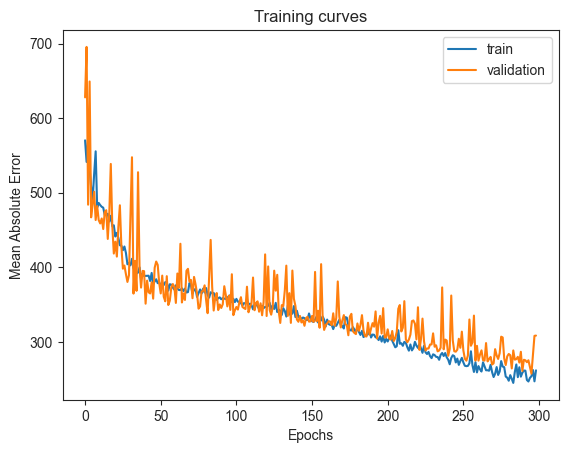

In [13]:
# plot history
plt.title("Training curves")
plt.plot(history.history['mean_absolute_error'][1:], label='train')
plt.plot(history.history['val_mean_absolute_error'][1:], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

244/244 [==============================] - 1s 5ms/step
MAE = 320


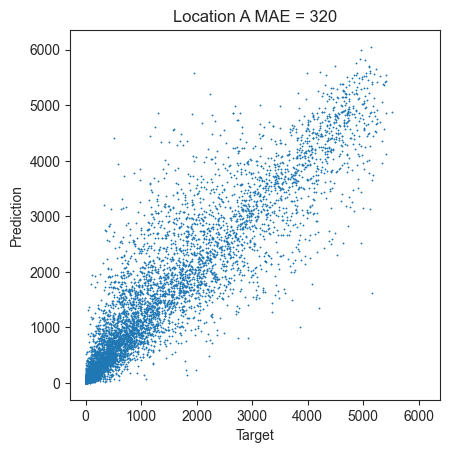

In [14]:
#model = MLP_model
# Make predictions every 15 minutes
Y_pred = model.predict(X_test.to_numpy())
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.0f}")
plt.axis("square")
plt.show()

In [17]:
# Save model

path = "./MLP_models/"+LOCATION+"_v4/"
model.save(path)

INFO:tensorflow:Assets written to: ./MLP_models/C_v4/assets


In [51]:
# Load model

path = "./MLP_models/"+LOCATION+"_v4/"
MLP_model = tf.keras.models.load_model(path)

### CNN regression
GPU is highly recommended (30s/epoch on CPU, 5s/epoch on GPU)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from sklearn.metrics import mean_absolute_error

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this line to use GPU

In [10]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, allow memory growth and select a GPU device
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
else:
    print("No GPU devices found. Using CPU.")

Physical GPUs: 1, Logical GPUs: 1


In [7]:
# Convert pandas dataframes to numpy arrays
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_val = X_val.to_numpy()
Y_val = Y_val.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
# Check for NaN values
print(np.isnan(X_train).any())
print(np.isnan(Y_train).any())
print(np.isnan(X_val).any())
print(np.isnan(Y_val).any())
print(np.isnan(X_test).any())
print(np.isnan(Y_test).any())

False
False
False
False
False
False


In [8]:
# Reshape to 3D
n_features=X_train.shape[1]
X_train_backup=X_train
X_train = X_train.reshape((-1,n_features//11,11))
X_val = X_val.reshape((-1,n_features//11,11))
X_test = X_test.reshape((-1,n_features//11,11))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(63040, 20, 11)
(7005, 20, 11)
(7783, 20, 11)


In [9]:
# Define hyperparameters and model architecture
input_shape = (X_train.shape[1],X_train.shape[2],1) # Shape of input data
output_shape = 1                                    # Shape of output data (scalar)
print(input_shape)

(20, 11, 1)


In [11]:
# Define model architecure
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape,padding="same"))
# model.add(MaxPooling2D(2,2))                        # MaxPooling
model.add(Conv2D(64,(3,3), activation='relu',padding="valid"))      # Convolution
model.add(MaxPooling2D(2,2))                        # MaxPooling
model.add(Conv2D(128,(3,3), activation='relu'))      # Convolution
#model.add(MaxPooling2D(2,2))
model.add(Flatten())                                # Flatten
# model.add(Dense(256, activation='relu'))             # Hidden layer
model.add(Dense(128, activation='relu'))             # Hidden layer
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))             # Hidden layer
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation='linear')) # Output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 11, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 9, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 128)               229504    
                                                        

In [14]:
# Training parameters
num_epochs = 100  
batch_size = 256

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics = 'MeanAbsoluteError')

# Train the model
history = model.fit(X_train, Y_train, 
          epochs=num_epochs, 
          batch_size=batch_size,
          validation_data=(X_val,Y_val),
          verbose=2)

# Save model
path = "./CNN_models/"+LOCATION+"_v5"
model.save(path)

# plot history
plt.title("Training curves")
plt.plot(history.history['mean_absolute_error'][1:], label='train')
plt.plot(history.history['val_mean_absolute_error'][1:], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

Epoch 1/100
247/247 - 7s - loss: 346989.6875 - mean_absolute_error: 350.2382 - val_loss: 204774.4062 - val_mean_absolute_error: 278.1853 - 7s/epoch - 28ms/step
Epoch 2/100
247/247 - 5s - loss: 343690.0938 - mean_absolute_error: 348.4296 - val_loss: 204582.6719 - val_mean_absolute_error: 273.7389 - 5s/epoch - 19ms/step
Epoch 3/100
247/247 - 4s - loss: 336283.9062 - mean_absolute_error: 345.2734 - val_loss: 203304.3594 - val_mean_absolute_error: 274.9739 - 4s/epoch - 18ms/step
Epoch 4/100
247/247 - 4s - loss: 342071.6250 - mean_absolute_error: 346.7361 - val_loss: 209260.0156 - val_mean_absolute_error: 281.3388 - 4s/epoch - 17ms/step
Epoch 5/100
247/247 - 4s - loss: 339021.6250 - mean_absolute_error: 345.7875 - val_loss: 204925.1719 - val_mean_absolute_error: 276.5803 - 4s/epoch - 17ms/step
Epoch 6/100
247/247 - 4s - loss: 334761.8125 - mean_absolute_error: 343.6305 - val_loss: 205873.8906 - val_mean_absolute_error: 277.2548 - 4s/epoch - 18ms/step
Epoch 7/100
247/247 - 4s - loss: 338592.

In [12]:
path = "./CNN_models/"+LOCATION+"_v4"
model = tf.keras.models.load_model(path)
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

244/244 [==============================] - 1s 5ms/step
MAE = 284


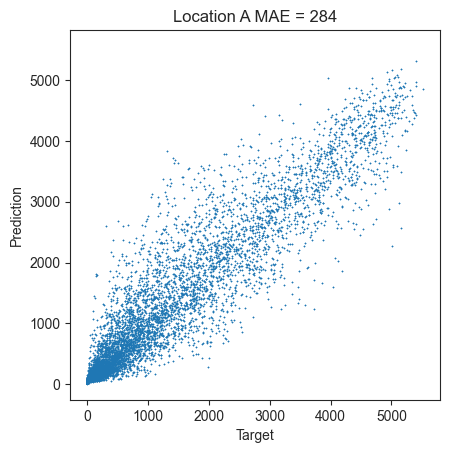

In [13]:
# Make predictions
Y_pred = model.predict(X_test)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(Y_test, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Location {LOCATION} MAE = {mae:.0f}")
plt.axis("square")
plt.show()

### LSTM

In [5]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this line to use GPU

In [25]:
def Sequential_Input_LSTM(df,target, input_sequence):
    df_np = df.to_numpy()
    target_np = target.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        Y = target_np[i + input_sequence]
        y.append(Y)
        
    return np.array(X), np.array(y)


n_input = 10    # Number of rows used as input

X, y = Sequential_Input_LSTM(X_Train,Y_Train, n_input)

In [26]:
def create_lstm_model(n_input, n_features):
    model = Sequential()
    model.add(InputLayer((n_input,n_features)))
    print((n_input,n_features))
    model.add(LSTM(100, return_sequences = True))     
    model.add(LSTM(100, return_sequences = True))
    model.add(LSTM(50))
    model.add(Flatten())
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    # model.summary()
    return model

In [27]:
n_splits=2
fold_scores = []

num_epochs=5
batch_size=64

tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Create a new instance of the LSTM model for each fold

    model1 = create_lstm_model(10,X_train_fold.shape[2])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

    model1.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_absolute_error'])

    model1.fit(X_train_fold, y_train_fold, 
            validation_data = (X_test_fold, y_test_fold), 
            epochs = num_epochs,
            batch_size=batch_size,
            callbacks = [early_stop])
    
    # Evaluate the model on the test data and calculate the regression score (e.g., MSE)
    test_predictions = model1.predict(X_test_fold)
    mae = mean_absolute_error(y_test_fold, test_predictions)
    fold_scores.append(mae)

average_mae = np.mean(fold_scores)
print("Average MAE:", average_mae)
print(fold_scores)

(10, 34)
Epoch 1/5
406/406 [==============================] - 26s 49ms/step - loss: 3022783.5000 - mean_absolute_error: 1122.6991 - val_loss: 2759485.5000 - val_mean_absolute_error: 1020.8489
Epoch 2/5
406/406 [==============================] - 20s 48ms/step - loss: 2656285.7500 - mean_absolute_error: 1045.7023 - val_loss: 2358026.5000 - val_mean_absolute_error: 962.0008
Epoch 3/5
406/406 [==============================] - 20s 49ms/step - loss: 2235843.2500 - mean_absolute_error: 1002.5322 - val_loss: 2021715.7500 - val_mean_absolute_error: 963.6328
Epoch 4/5
406/406 [==============================] - 20s 49ms/step - loss: 2657488.0000 - mean_absolute_error: 1095.9399 - val_loss: 3025452.5000 - val_mean_absolute_error: 1095.6337
Epoch 5/5
811/811 [==============================] - 10s 10ms/step
(10, 34)
Epoch 1/5
811/811 [==============================] - 43s 46ms/step - loss: 2929974.0000 - mean_absolute_error: 1082.4351 - val_loss: 2515559.0000 - val_mean_absolute_error: 966.9447
Epo

In [28]:
# Create a TimeSeriesSplit object with the desired number of splits
n_splits=1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize a list to store the split indices
split_indices = []

# Split the data using Time Series Split
for train_index, val_index in tscv.split(X_Train):
    split_indices.append((train_index, val_index))

In [29]:
num_epochs = 2
batch_size = 64

fold_scores = []
learning_curves = []

# Time Series Cross validation
for train_index, val_index in split_indices:
    X_train_fold = X_Train.iloc[train_index].to_numpy()
    Y_train_fold = Y_Train.iloc[train_index].to_numpy()
    X_val_fold = X_Train.iloc[val_index].to_numpy()
    Y_val_fold = Y_Train.iloc[val_index].to_numpy()


    # Reshape the input data for the LSTM model
    input_shape = (X_train_fold.shape[1], 1)  # Assuming one feature per time step
    X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

    # Create and compile the LSTM model
    model = create_lstm_model(input_shape)

    # Train the model
    history = model.fit(X_train_fold,
                        Y_train_fold,
                        validation_data=(X_val_fold, Y_val_fold),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        verbose=1)
    learning_curves.append(history)

    # Evaluate the model on the validation data
    Y_pred_fold = model.predict(X_val_fold)

    # Reshape Y_pred_fold and Y_val_fold to be 2D arrays
    # Y_pred_fold = Y_pred_fold.reshape((Y_pred_fold.shape[0], -1))
    # Y_val_fold = Y_val_fold.reshape((Y_val_fold.shape[0], -1))
    # print(Y_pred_fold.shape)
    # print(Y_val_fold.shape)

    mae = mean_absolute_error(Y_val_fold, Y_pred_fold)
    fold_scores.append(mae)
    print(f"Validation MAE: {mae}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 34, 50)            10400     
                                                                 
 flatten (Flatten)           (None, 1700)              0         
                                                                 
 dense_9 (Dense)             (None, 10)                17010     
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 27,421
Trainable params: 27,421
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
244/244 [==============================] - 10s 31ms/step - loss: 2361826.5000 - mean_absolute_error: 942.9780 - val_loss: 3365397.5000 - val_mean_absolute_error: 1228.1620
Epoch 2/2
487/487 [==============================] - 4s 7ms/step
(15565, 1)
(15565, 1)
Validation MAE: 1045.321304922133
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 34, 50)            10400     
                                                                 
 flatten_1 (Flatten)         (None, 1700)              0         
                                                                 
 dense_11 (Dense)            (None, 10)                17010     
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 

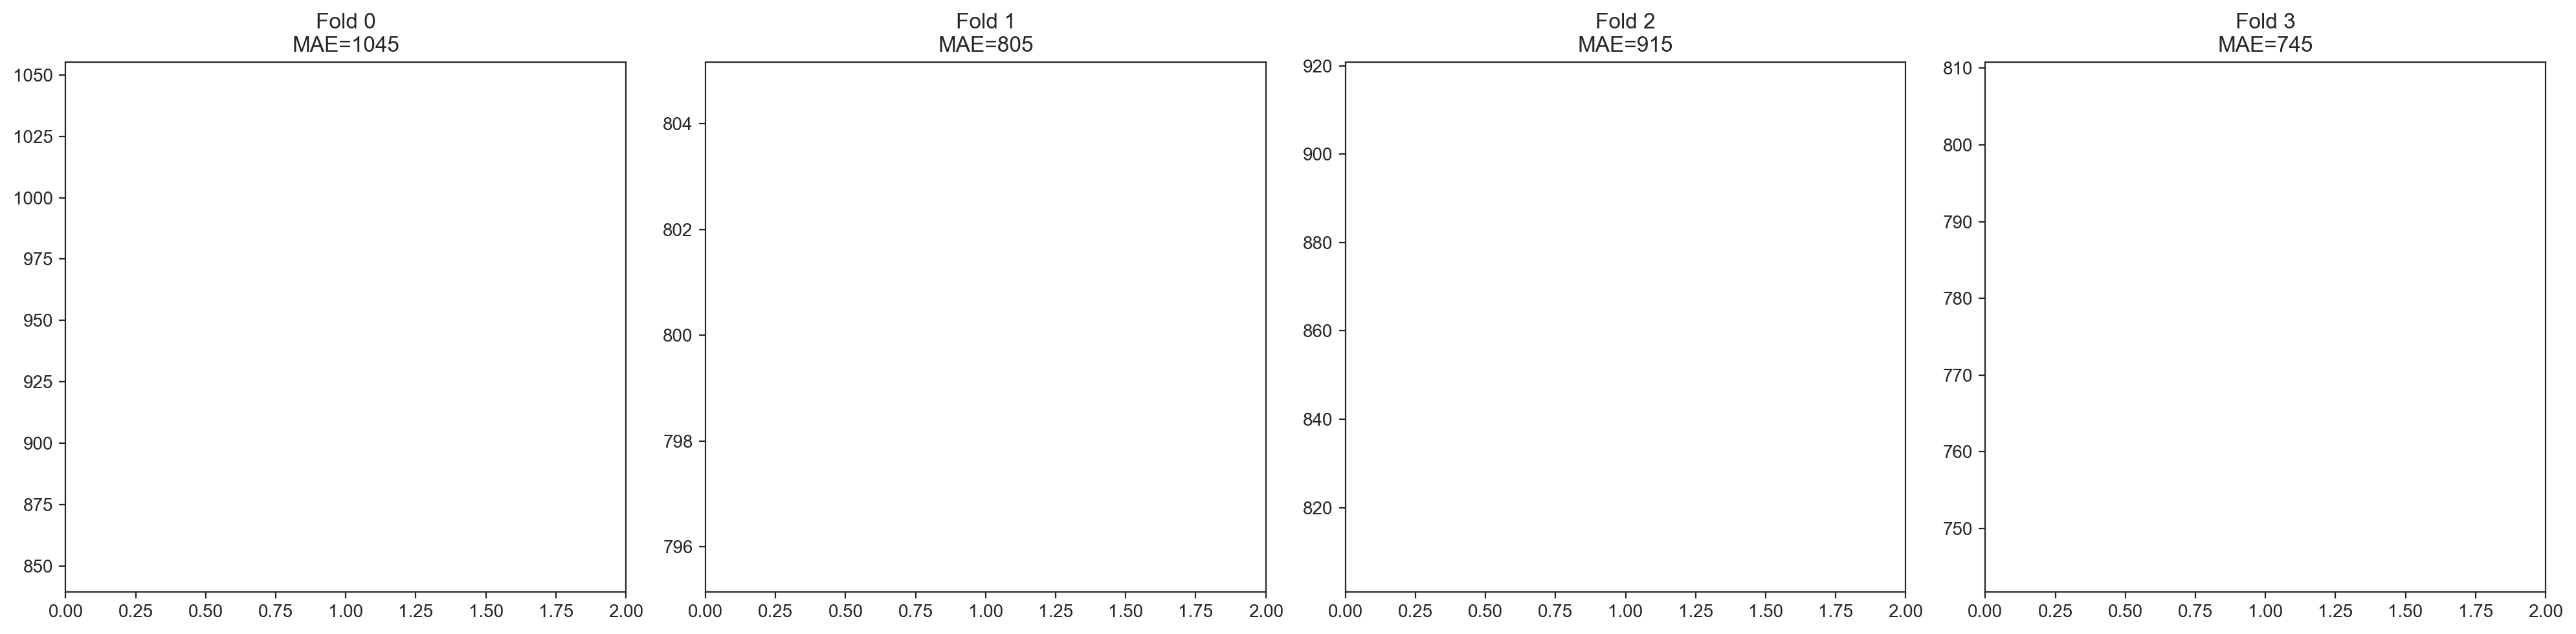

In [40]:
fig,ax=plt.subplots(nrows=1,ncols=n_splits,figsize=(20,5),dpi=200)
for index,history in enumerate(learning_curves):
    ax[index].plot(history.history['mean_absolute_error'][1:])
    ax[index].plot(history.history['val_mean_absolute_error'][1:])
    ax[index].set_title(f"Fold {index}\nMAE={fold_scores[index]:.0f}")
    ax[index].set_xlim([0,num_epochs])
fig.tight_layout()
plt.show()

In [33]:
learning_curves[0].history

{'loss': [2361826.5, 1603075.125],
 'mean_absolute_error': [942.97802734375, 849.3168334960938],
 'val_loss': [3365397.5, 1625919.875],
 'val_mean_absolute_error': [1228.1619873046875, 1045.3218994140625]}

335/335 [==============================] - 1s 3ms/step
MAE = 48


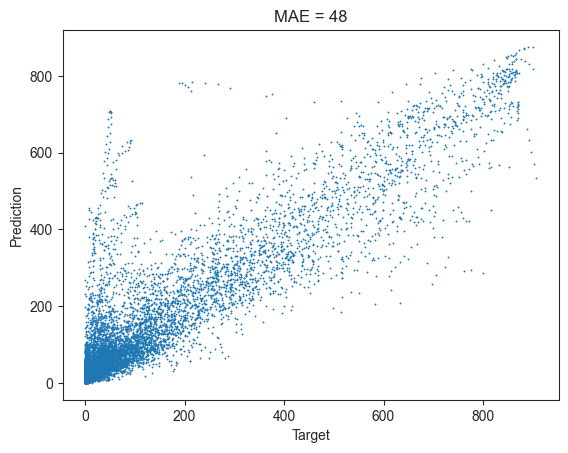

In [51]:
# Make predictions every 15 minutes
Y_pred = model.predict(test_X)
#Y_pred = model.predict(X_test)
Y_pred[Y_pred<0]=0

mae = mean_absolute_error(test_y, Y_pred)

print(f"MAE = {mae:.0f}")


plt.figure()
plt.scatter(test_y,Y_pred,s=0.05,marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MAE = {mae:.0f}")
plt.show()

### Stacking models

I think the cross validation scores are bad because i don't know how to perform cross validation.
Here we will try to stack models to improve the prediction. The idea is the following, with `X_Test` the data that models at level 0 have not seen during training :

    X_Test -> [X_Test_train, X_Test_test]

                               level 0                                                          level 1
                    | model1 -> predictions 1 |     concatenate predictions with      |                           |
    X_Test_train -> | model2 -> predictions 2 | ->  X_Test_train, do feature       -> | model -> final prediction |
                    | model3 -> predictions 3 |     engineering and stuff             |                           |

In [ ]:
# load level0 catboost model for the current location
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_lag1_minmax.cbm",format='cbm')

---
## Tests

In [234]:
X_Train['date_forecast'].dtype

dtype('<M8[us]')

In [118]:
print(new_df['date_forecast']-pd.to_timedelta(15, unit='minutes'))
print(lagged_df['date_forecast'])

1       2019-01-01 10:00:00
2       2019-01-01 10:15:00
3       2019-01-01 10:30:00
4       2019-01-01 10:45:00
5       2019-01-01 11:00:00
                ...        
53592   2023-04-30 18:45:00
53593   2023-04-30 19:00:00
53594   2023-04-30 19:15:00
53595   2023-04-30 19:30:00
53596   2023-04-30 19:45:00
Name: date_forecast, Length: 53596, dtype: datetime64[ns]
1       2019-01-01 10:30:00
2       2019-01-01 10:45:00
3       2019-01-01 11:00:00
4       2019-01-01 11:15:00
5       2019-01-01 11:30:00
                ...        
53592   2023-04-30 19:15:00
53593   2023-04-30 19:30:00
53594   2023-04-30 19:45:00
53595   2023-04-30 20:00:00
53596                   NaT
Name: date_forecast, Length: 53596, dtype: datetime64[us]


In [16]:
# Prediction on the whole training dataset (dumb)
# Y = MLP_model.predict(X_train_lagged_selected)
n_features=X_train_lagged_selected.shape[1]
Y = model.predict((X_train_lagged_selected.to_numpy()).reshape((-1,n_features//4,4)))

Y[Y<0]=0

mae = mean_absolute_error(Y, Y_train_selected)

2433/2433 [==============================] - 15s 6ms/step


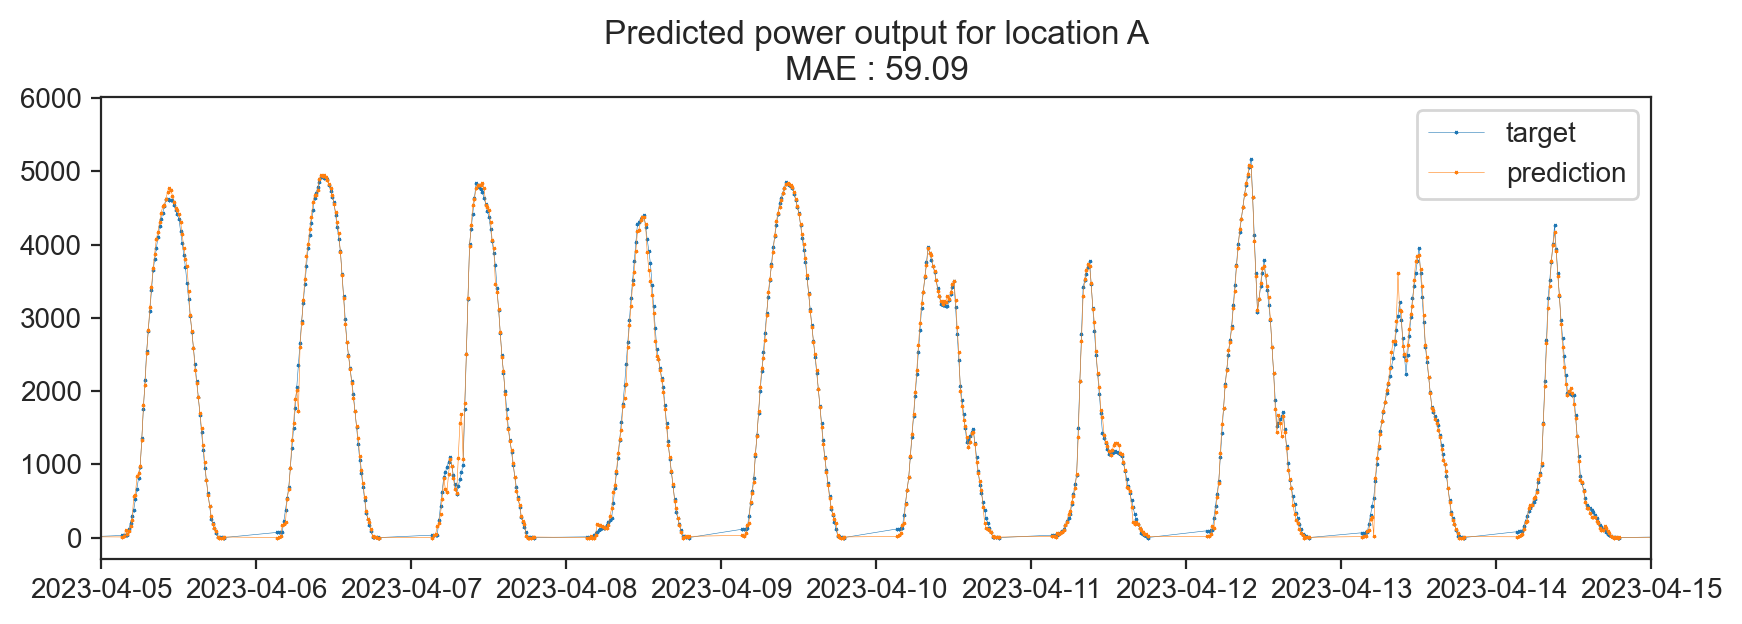

In [17]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(X_Train['date_forecast'],Y_train_selected,'-*',linewidth = 0.2, markersize = 0.8, label = 'target')
plt.plot(X_Train['date_forecast'],Y, '-*', linewidth = 0.2, markersize = 0.8, label = 'prediction')
plt.title(f"Predicted power output for location {LOCATION}\nMAE : {mae:.2f}")
plt.legend()
plt.xlim([pd.to_datetime('2023-04-05'),pd.to_datetime('2023-04-15')])
plt.show()

## Make a prediction for Kaggle

### Catboost

In [54]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("CatBoost_models/CatBoost"+LOCATION+"_test.cbm",format='cbm')

In [55]:
# Predict on the X_test_estimated dataset
Y_test_estimated = pd.DataFrame()
pv_measurement =  catboost_model.predict(X_Test)
pv_measurement[pv_measurement<0]=0
Y_test_estimated['prediction'] = pv_measurement

Y_test_estimated['time'] = X_Test_full['date_forecast']
Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')

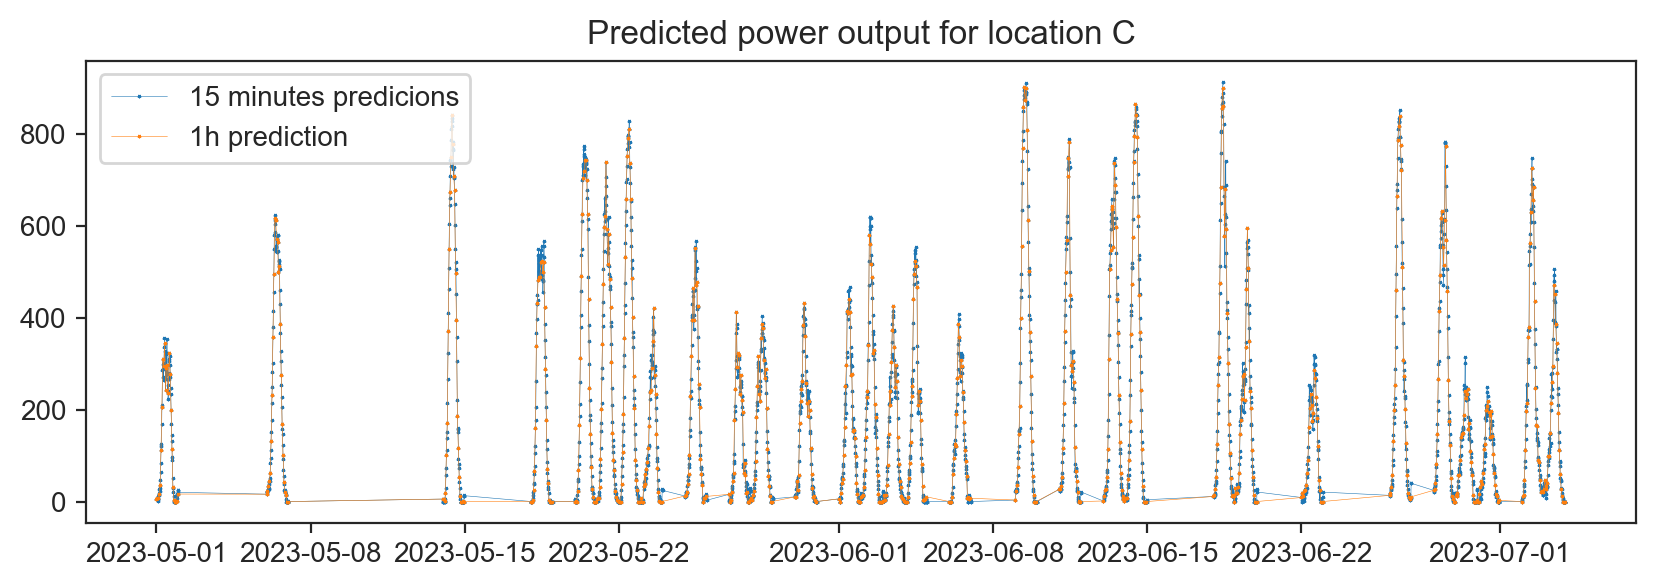

In [56]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(Y_test_estimated['time'],Y_test_estimated['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(Y_test_estimated_round['time'],Y_test_estimated_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()

plt.show()

In [52]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = Y_test_estimated_round['prediction']

In [47]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = Y_test_estimated_round['prediction']

In [57]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = Y_test_estimated_round['prediction']

In [62]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

index  prediction    id
0         0    0.000000     0
1         4    0.000000     1
2         8   16.271863     2
3        12    0.000000     3
4        16  179.800333     4
...     ...         ...   ...
2155   2860   28.300571  2155
2156   2864   13.016177  2156
2157   2868    0.000000  2157
2158   2872    0.000000  2158
2159   2876    0.000000  2159

[2160 rows x 3 columns]

In [63]:
# SAVE TO CSV 
name = "new_submission"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### MLP

In [29]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this line to use GPU

# Load model
path = "./MLP_models/"+LOCATION+"_v4/"
MLP_model = tf.keras.models.load_model(path)

In [30]:
# Make prediction
X_Test_np = X_Test.to_numpy()

# Make predictions
prediction=pd.DataFrame()
pv_measurement =  MLP_model.predict(X_Test_np).flatten()
pv_measurement[pv_measurement<0]=0
prediction['prediction'] = pv_measurement

# select round hours predictions
prediction['time'] = X_Test_full['date_forecast']
prediction_round = select_o_clock(prediction,'time')

90/90 [==============================] - 1s 4ms/step


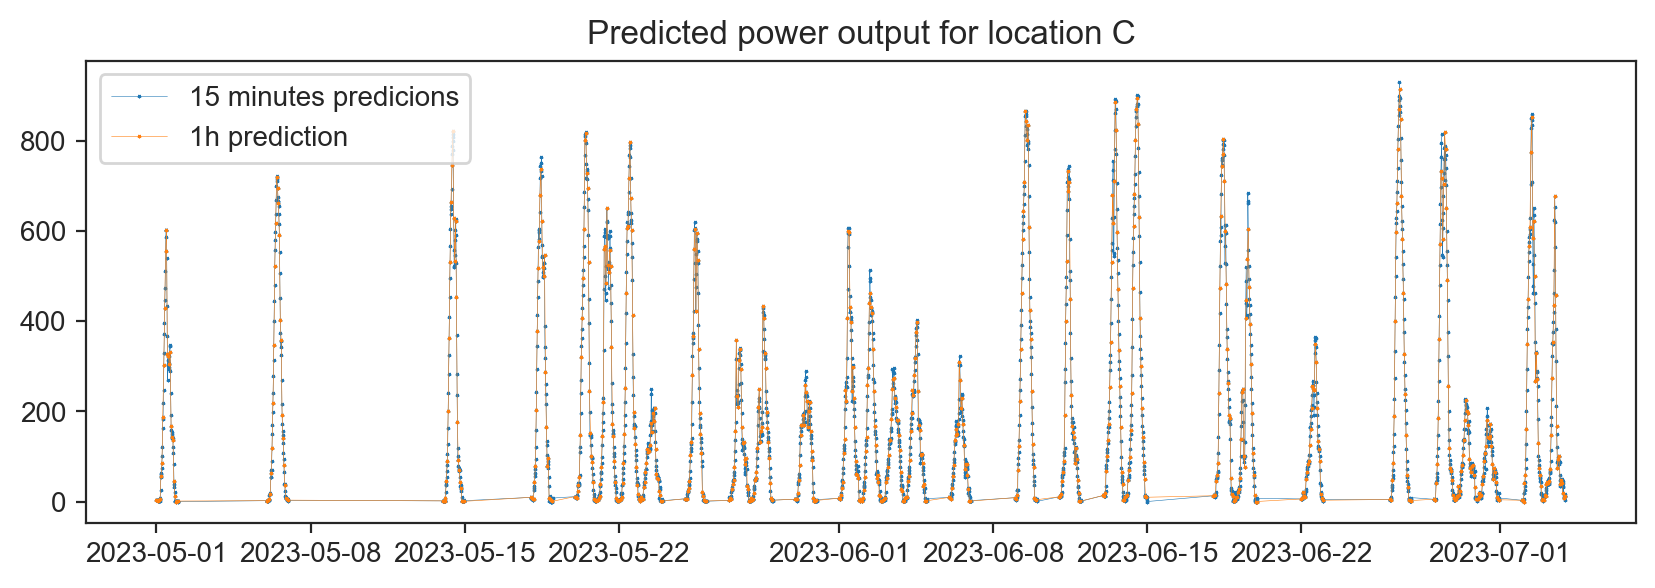

In [31]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(prediction['time'],prediction['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(prediction_round['time'],prediction_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
#plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-02')])
plt.show()

In [19]:
# ONLY RUN FOR LOCATION A
PREDICTION_A = prediction_round['prediction']

In [25]:
# ONLY RUN FOR LOCATION B
PREDICTION_B = prediction_round['prediction']

In [32]:
# ONLY RUN FOR LOCATION C
PREDICTION_C = prediction_round['prediction']

In [33]:
# Concatenate all 3 predictions
submission = pd.concat([PREDICTION_A, PREDICTION_B, PREDICTION_C]).reset_index()
# Add id colum 
submission['id'] = submission.index
submission

index  prediction    id
0         0    6.979234     0
1         4    7.392717     1
2         8   12.864594     2
3        12   22.748631     3
4        16  139.383270     4
...     ...         ...   ...
2155   2860   48.244072  2155
2156   2864   40.914688  2156
2157   2868   18.860514  2157
2158   2872    7.297514  2158
2159   2876   11.657415  2159

[2160 rows x 3 columns]

In [34]:
# SAVE TO CSV 
name = "submission_MLP_v4_new_loader"
submission.to_csv("Submissions/"+name+".csv",
                  columns=['id','prediction'],
                  index=False,
                  encoding='utf8')

### Compare

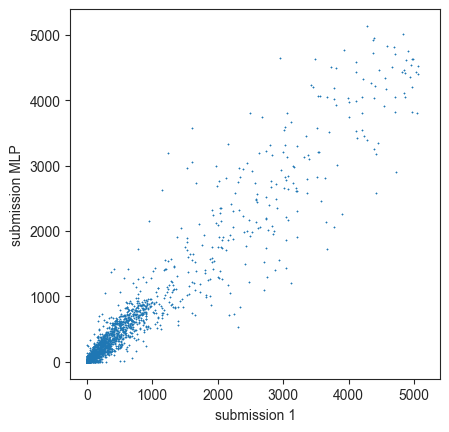

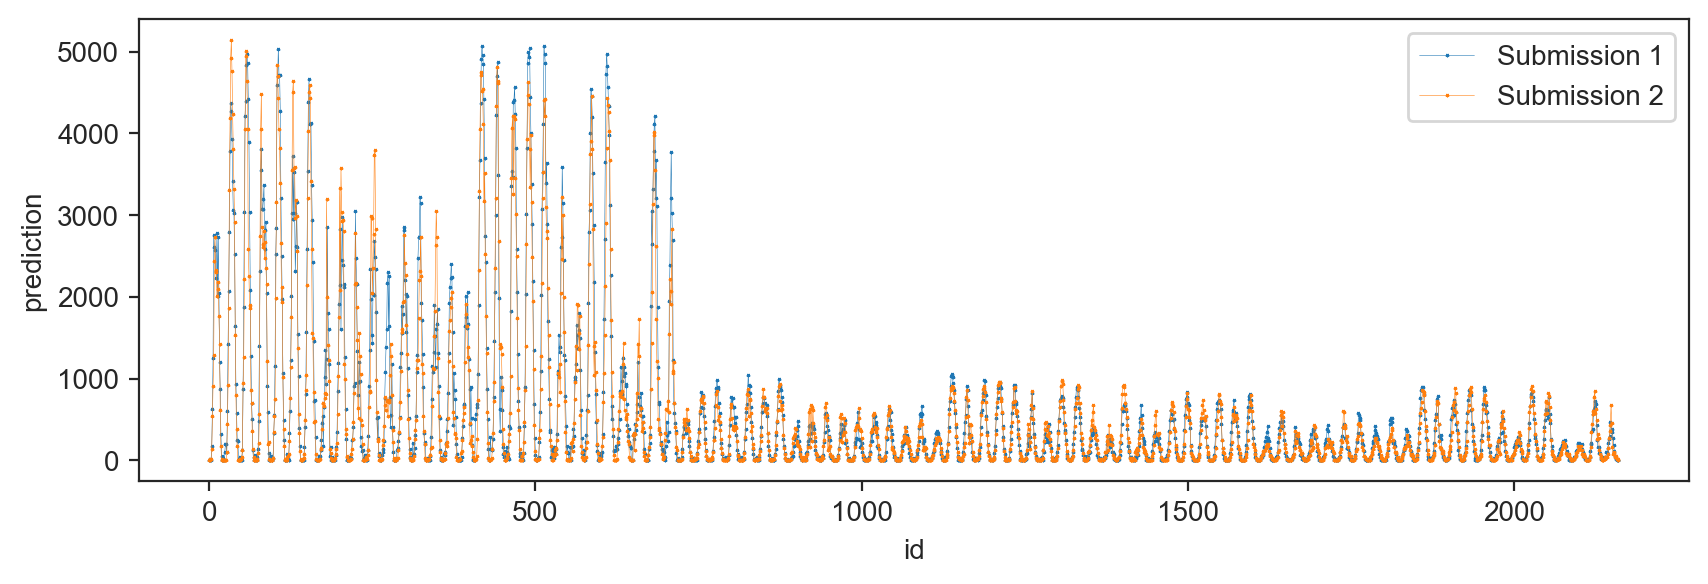

In [35]:
# Compare with previous solutions
sub1 = pd.read_csv('Submissions/submission3.csv')
sub2 = pd.read_csv('Submissions/submission_MLP_v4_new_loader.csv')
# x=np.arange(0,len(PREDICTION_A))
plt.figure()
plt.scatter(sub1['prediction'],sub2['prediction'],s=0.05,marker="*")
# plt.scatter(sub1['prediction'][:len(PREDICTION_A)],PREDICTION_A,s=0.05,marker="*")
plt.xlabel("submission 1")
plt.ylabel("submission MLP")
# plt.xscale("log")
# plt.yscale("log")
plt.axis("square")
plt.show()

plt.figure(figsize=(10,3),dpi=200)
# plt.plot(x,PREDICTION_A,'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission MLP')
plt.plot(sub1['id'],sub1['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission 1')
# plt.plot(x,sub1['prediction'][:len(PREDICTION_A)],'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission 1')
plt.plot(sub2['id'],sub2['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label = 'Submission 2')
plt.xlabel("id")
plt.ylabel("prediction")
plt.legend()
plt.show()
